# This a jupyter notebook guide on compartment analysis for chr2

by Pu Zheng

2020.06.06


## Import packages

In [1]:
# imports
import sys, os, glob, time, copy
import numpy as np
import scipy
import pickle

sys.path.append(os.path.abspath(r"..\."))

import source as ia

from scipy.signal import find_peaks
from scipy.spatial.distance import cdist,pdist,squareform

print(os.getpid()) # print this so u can terminate through cmd / task-manager

44772


## Import plotting

In [2]:
# Required plotting setting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
_font_size = 7.5

In [3]:
# Required plotting parameters
from source.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size

In [4]:
# figure folder
parent_figure_folder = r'\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\final_figures'
figure_folder = os.path.join(parent_figure_folder, 'Chr2_figures_new_data')
print(figure_folder)
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)
    print("generating this folder")

\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\final_figures\Chr2_figures_new_data
generating this folder


# 0. Load data

In [5]:
## chr2 dataset
# load data containing candidates
data_folder = r'\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\Repicked_chromosome_data'

data_rep1 = pickle.load(open(os.path.join(data_folder, r'review_finalEM_chr2.pkl'), 'rb'))

data_rep2 = pickle.load(open(os.path.join(data_folder, r'chr2_repeat_after_selection.pkl'), 'rb'))

In [7]:
data_rep1['zxy'].shape

(3066, 935, 3)

In [9]:
# P and q arm crop
p_crop = slice(0, 357)
q_crop = slice(357, len(data_rep1['zxy'][0]))

In [10]:
print(p_crop, q_crop)

slice(0, 357, None) slice(357, 935, None)


## genomic coordinate info

In [11]:
# reference folder
ref_folder = r'\\10.245.74.69\Chromatin_NAS_3\20191007_CTP07_chr2\Analysis'
# load genomic positions
genomic_dic = ia.get_img_info.Load_Region_Positions(ref_folder)
mid_positions = np.array([_v['midpoint'] for _k,_v in genomic_dic.items()])

genomic_distance_map = squareform(pdist(mid_positions[:,np.newaxis]))
genomic_distance_entries = genomic_distance_map[np.triu_indices(len(genomic_distance_map),1)]

genomic_positions_Mb = np.round(mid_positions/1e6, 2)
# genomic dist map
genomic_dist_mat = squareform(pdist(genomic_positions_Mb[:,np.newaxis]))

region_starts = np.array([_v['start'] for _k,_v in genomic_dic.items()], dtype=np.int)
region_ends = np.array([_v['end'] for _k,_v in genomic_dic.items()], dtype=np.int)

- Importing csv file: \\10.245.74.69\Chromatin_NAS_3\20191007_CTP07_chr2\Analysis\Region_Positions.csv
- header: ['region', 'chr', 'start', 'end', 'midpoint']
-- 935 genomic regions loaded!


# Population-averaged behavior for chr2

In [26]:
zxys_rep1_list = np.array(data_rep1['zxy'])
distmap_rep1_list = np.array([squareform(pdist(_zxy)) for _zxy in zxys_rep1_list])
# calculate contact freq map
contact_th = 500
contact_rep1_map = np.nanmean(distmap_rep1_list<contact_th, axis=0)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [27]:
# load Hi-C
# load Hi-C
hic_map = np.load(r'Z:\Hi-C\chr2_hg38_50000.npy')
region_ids = pickle.load(open(os.path.join(r'\\10.245.74.158\Chromatin_NAS_4\201911_chr2_processed_data', 
                                           'kept_reg_ids_250kb.pkl'), 'rb'))

region_indices = np.array(region_ids,dtype=np.int)
hic_map = hic_map[region_indices][:,region_indices]
hic_map[np.isnan(hic_map)] = 0

## Fig S2E: chr2 proximity frequency map

\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\final_figures\Chr2_figures_new_data


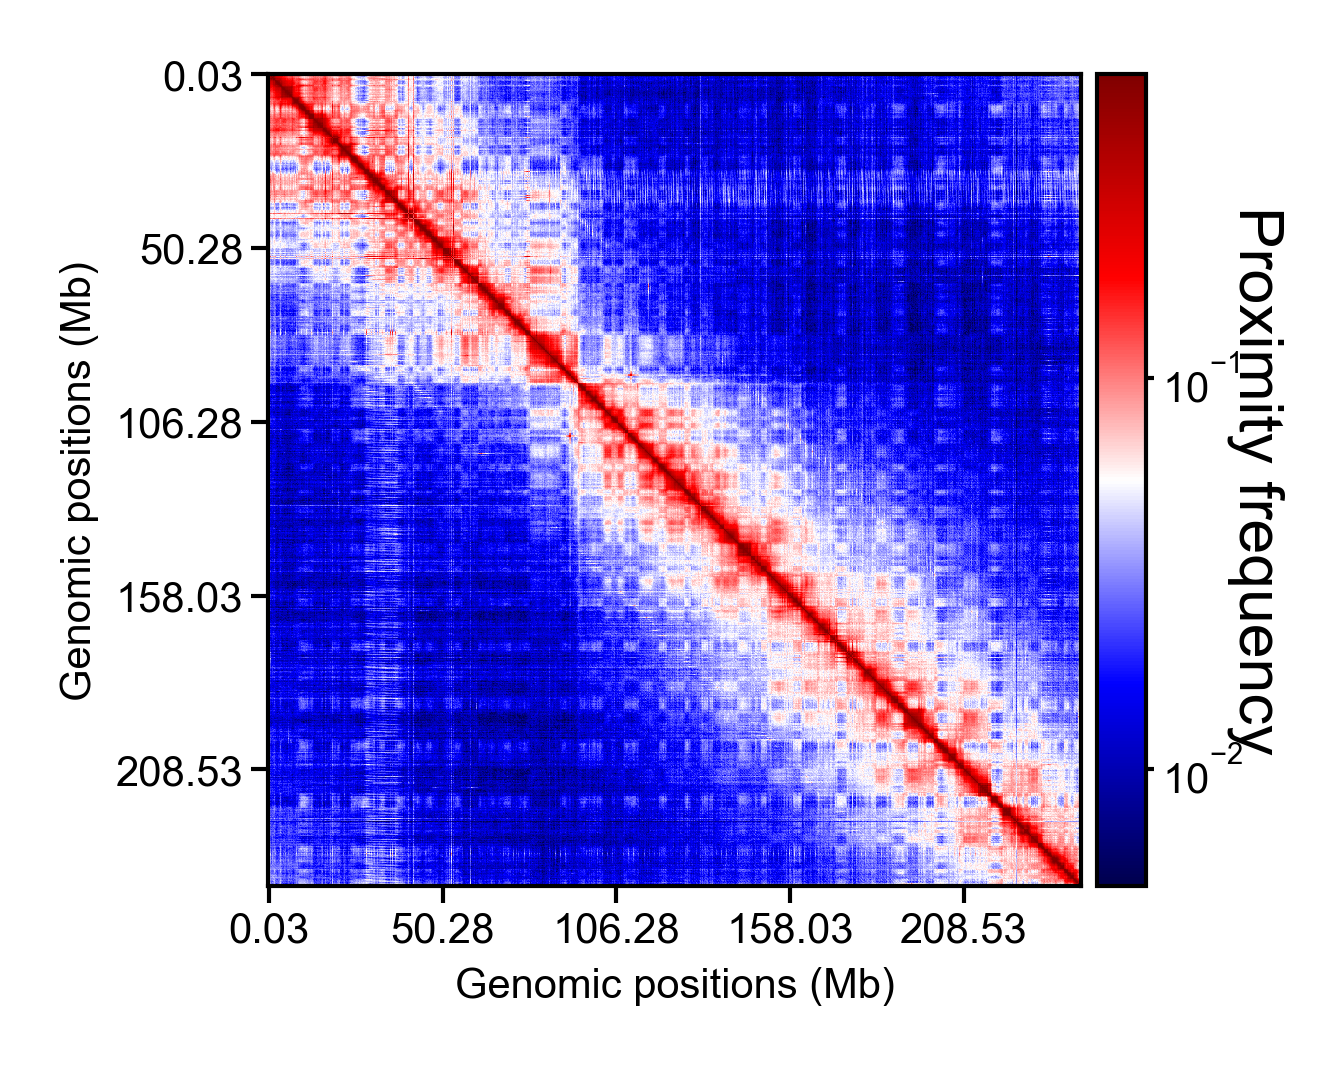

In [29]:
from source.figure_tools.distmap import plot_distance_map
print(figure_folder)
from matplotlib.colors import LogNorm

contact_limits = [0.005, 0.6]
contact_norm = LogNorm(vmin=np.min(contact_limits), 
                       vmax=np.max(contact_limits))
contact_cmap = matplotlib.cm.get_cmap('seismic')
contact_cmap.set_bad(color=[0.,0.,0.,1])

distmap_ax = plot_distance_map(contact_rep1_map, 
                               cmap=contact_cmap,
                               color_limits=contact_limits,
                               color_norm=contact_norm,
                               tick_labels=genomic_positions_Mb, 
                               ax_label='Genomic positions (Mb)', 
                               colorbar_labels='Proximity frequency',
                               save=False, save_folder=figure_folder, 
                               save_basename=f'FigS2E_chr2_proximity_freq_map.pdf',
                               font_size=5)

## 0.2 compartment calling

## Fig S2F: PC1 barplot for p and q arm

## P-arm

In [30]:
# Do PCA
from sklearn.decomposition import PCA

LinregressResult(slope=-0.526607400744866, intercept=6.0182845456041045, rvalue=-0.8615273458668871, pvalue=0.0, stderr=0.0012311113490534084)
LinregressResult(slope=-0.722803338678619, intercept=13.360714131321757, rvalue=-0.7250408584341543, pvalue=0.0, stderr=0.0030186725566035957)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


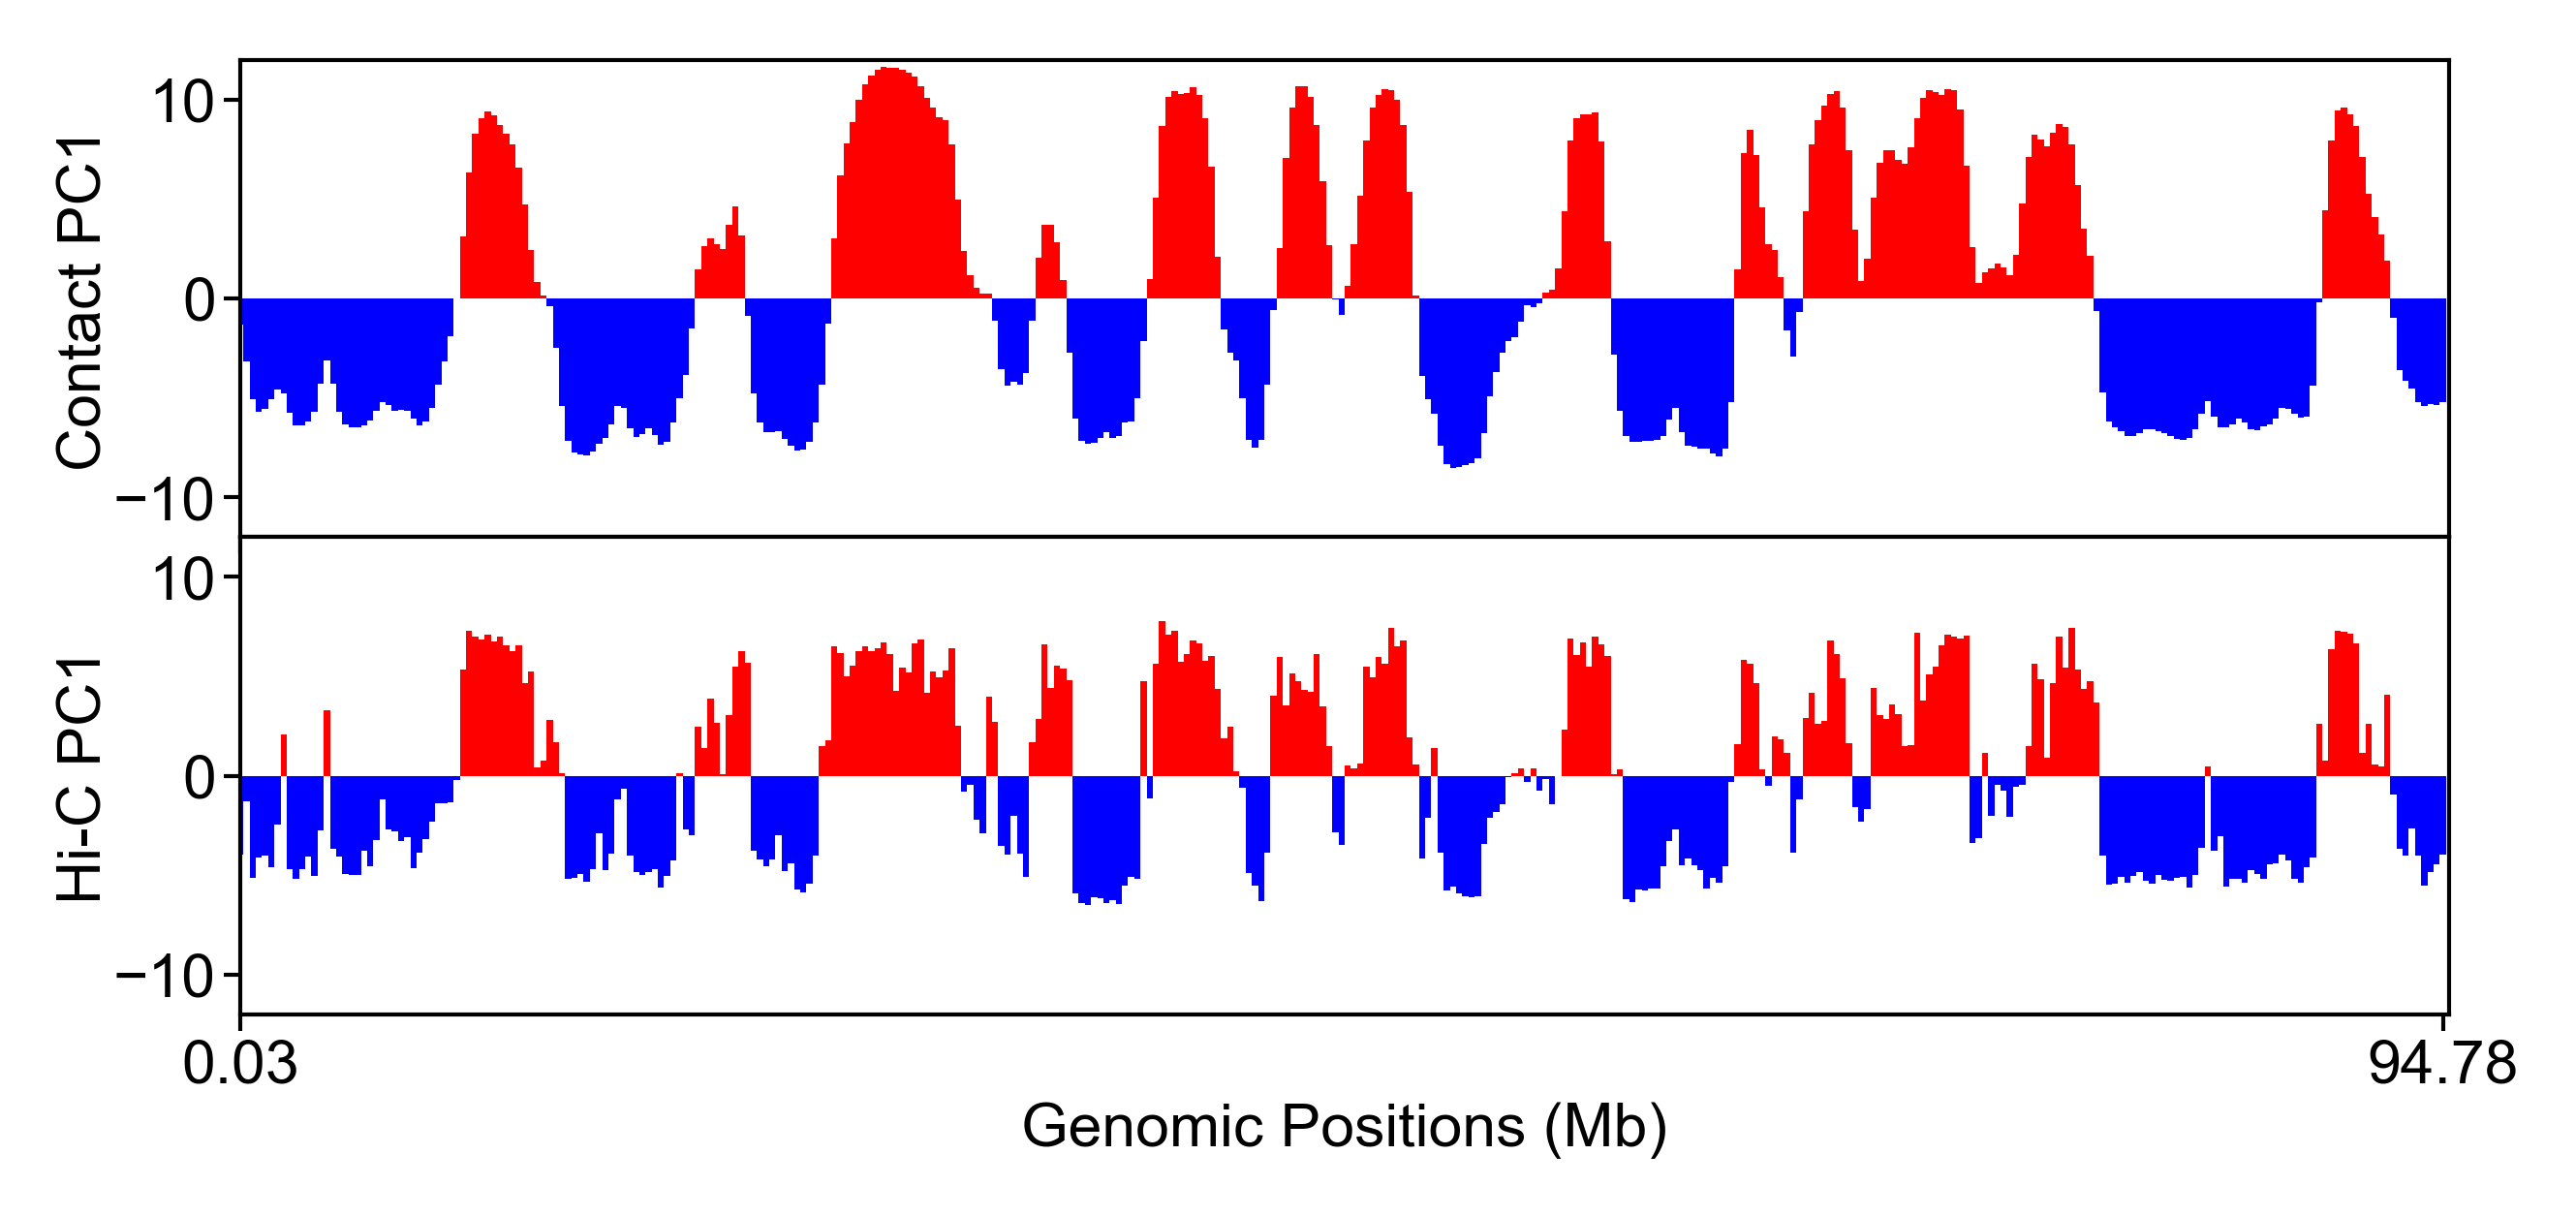

In [36]:
gaussian_sigma = 1
hic_sigma = 0.25

## p arm, proximity
p_gd_map = genomic_distance_map[p_crop, p_crop]
p_contact_rep1_map = contact_rep1_map[p_crop, p_crop]
# normalize genomic distance effect
genomic_distance_entries = p_gd_map[np.triu_indices(len(p_gd_map),1)]
contact_entries = p_contact_rep1_map[np.triu_indices(len(p_contact_rep1_map),1)]
p_contact_kept = (genomic_distance_entries > 0) * (contact_entries > 0)
p_contact_lr = scipy.stats.linregress(np.log(genomic_distance_entries[p_contact_kept]), 
                                      np.log(contact_entries[p_contact_kept]))
print(p_contact_lr)
p_normalization_mat = np.exp(np.log(p_gd_map) * p_contact_lr.slope + p_contact_lr.intercept)
for _i in range(len(p_normalization_mat)):
    p_normalization_mat[_i,_i] = 1
p_normed_contact_rep1_map = p_contact_rep1_map / p_normalization_mat
# apply gaussian
from scipy.ndimage import gaussian_filter

p_contact_corr_rep1_map = np.corrcoef(gaussian_filter(p_normed_contact_rep1_map, gaussian_sigma))
# PCA
p_contact_model_rep1 = PCA(1)
p_contact_model_rep1.fit(p_contact_corr_rep1_map)
p_contact_pc1_rep1 = np.reshape(p_contact_model_rep1.fit_transform(p_contact_corr_rep1_map), -1)

## p arm, Hi-C
p_gd_map = genomic_distance_map[p_crop, p_crop]
p_hic_map = hic_map[p_crop, p_crop]
# normalize genomic distance effects
genomic_distance_entries = p_gd_map[np.triu_indices(len(p_gd_map),1)]
hic_entries = p_hic_map[np.triu_indices(len(p_hic_map),1)]
p_hic_kept = (genomic_distance_entries > 0) * (hic_entries > 0)
p_hic_lr = scipy.stats.linregress(np.log(genomic_distance_entries[p_hic_kept]), 
                              np.log(hic_entries[p_hic_kept]))
print(p_hic_lr)
p_normalization_mat = np.exp(np.log(p_gd_map) * p_hic_lr.slope + p_hic_lr.intercept)
#for _i in range(len(p_normalization_mat)):
#    p_normalization_mat[_i,_i] = 1
p_normed_hic_map = p_hic_map / p_normalization_mat
# apply gaussian
from scipy.ndimage import gaussian_filter

p_hic_corr_map = np.corrcoef(gaussian_filter(p_normed_hic_map, hic_sigma))
# PCA
p_hic_model = PCA(1)
p_hic_model.fit(p_hic_corr_map)
p_hic_pc1 = np.reshape(p_hic_model.fit_transform(p_hic_corr_map), -1)


# Plot vs. Hi-C
## pc1 barplot
fig, ax = plt.subplots(figsize=(_double_col_width, _single_col_width), dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[1,1], hspace=0., wspace=0.)
contact_ax = plt.subplot(grid[0])
contact_ax.bar(np.where(p_contact_pc1_rep1>=0)[0],
               p_contact_pc1_rep1[p_contact_pc1_rep1>=0],
               width=1, color='r', label='A')
contact_ax.bar(np.where(p_contact_pc1_rep1<0)[0],
               p_contact_pc1_rep1[p_contact_pc1_rep1<0],
               width=1, color='b', label='B')
contact_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in contact_ax.spines.items()]
contact_ax.set_ylim([-12,12])
contact_ax.set_yticks([-10,0,10])
contact_ax.set_ylabel("Contact PC1", fontsize=_font_size, labelpad=0)

# hic-ax
hic_ax = plt.subplot(grid[1], sharex=contact_ax)

hic_ax.bar(np.where(p_hic_pc1>=0)[0],
               p_hic_pc1[p_hic_pc1>=0],
               width=1, color='r', label='A')
hic_ax.bar(np.where(p_hic_pc1<0)[0],
               p_hic_pc1[p_hic_pc1<0],
               width=1, color='b', label='B')
hic_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in hic_ax.spines.items()]
hic_ax.set_ylim([-12,12])
hic_ax.set_yticks([-10,0,10])
hic_ax.set_ylabel("Hi-C PC1", fontsize=_font_size, labelpad=0)

# set x
hic_ax.set_xlim([0, len(p_contact_pc1_rep1)])
_xticks = [0, len(p_contact_pc1_rep1)-1]
hic_ax.set_xticks(_xticks)
hic_ax.set_xticklabels(genomic_positions_Mb[_xticks])
hic_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1)

plt.savefig(os.path.join(figure_folder, f'FigS2F1_chr2_p_arm_PC1_barplot_rep1.pdf'), transparent=True)

plt.show()

## q-arm

LinregressResult(slope=-0.6421990444359295, intercept=7.800101150649752, rvalue=-0.9192579249503052, pvalue=0.0, stderr=0.0006734644464636403)
LinregressResult(slope=-0.7451356470768307, intercept=13.73025351238045, rvalue=-0.7769559406456998, pvalue=0.0, stderr=0.0018034121285637678)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


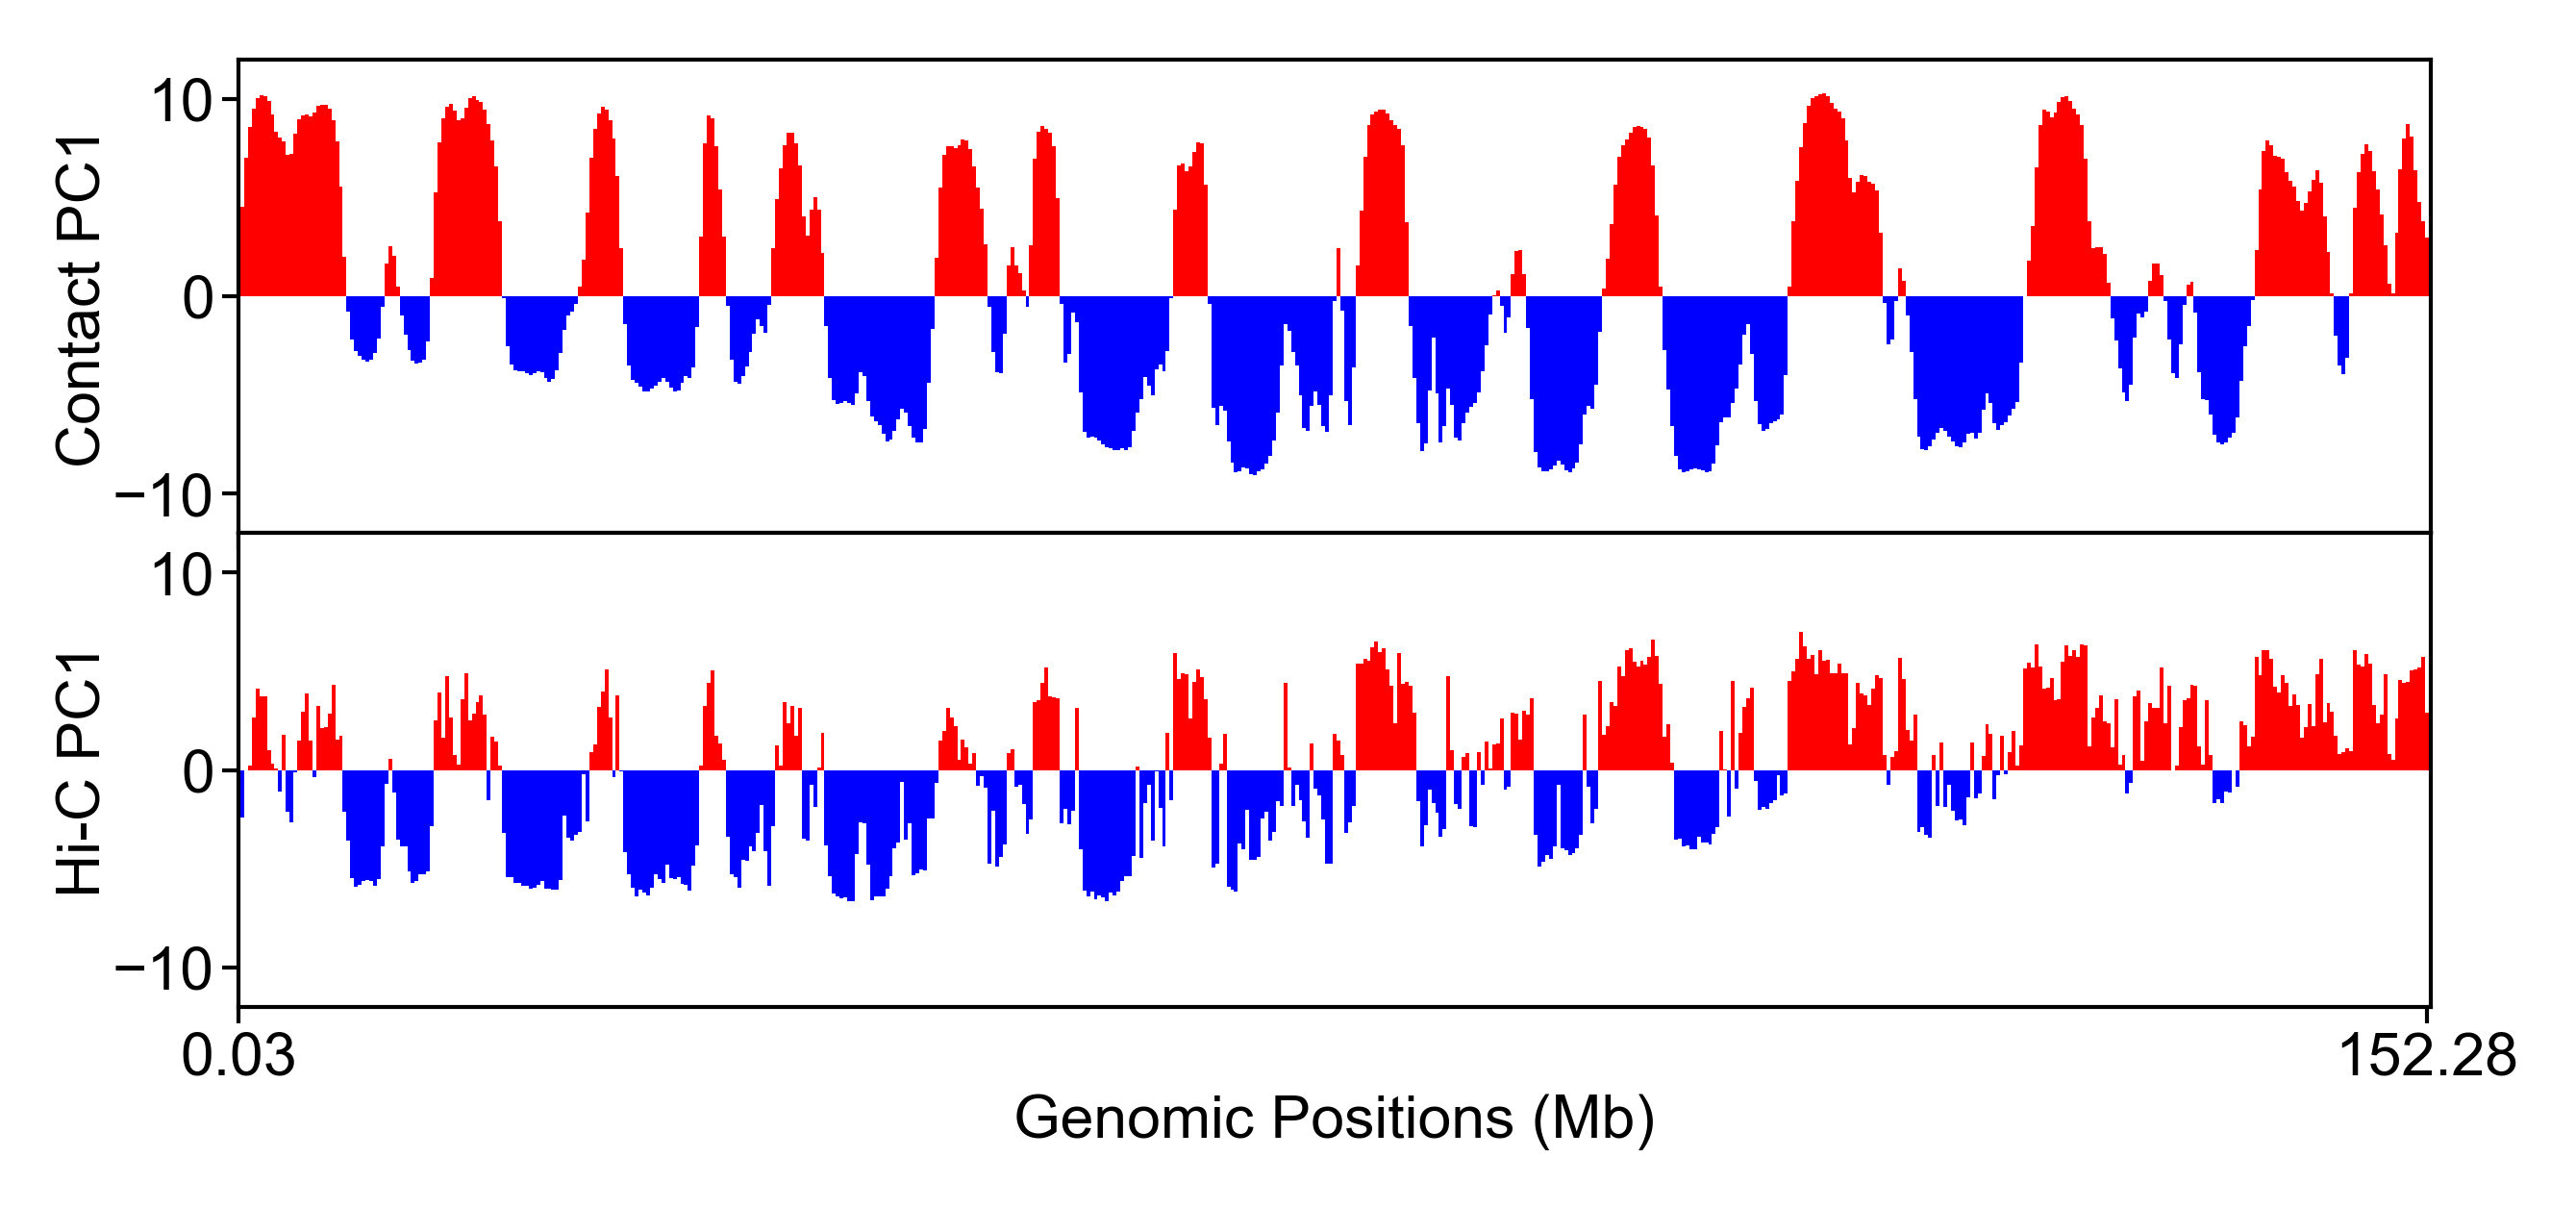

In [37]:
gaussian_sigma = 1
hic_sigma = 0.25

## q arm, proximity
q_gd_map = genomic_distance_map[q_crop, q_crop]
q_contact_rep1_map = contact_rep1_map[q_crop, q_crop]
# normalize genomic distance effects
genomic_distance_entries = q_gd_map[np.triu_indices(len(q_gd_map),1)]
contact_entries = q_contact_rep1_map[np.triu_indices(len(q_contact_rep1_map),1)]
q_contact_kept = (genomic_distance_entries > 0) * (contact_entries > 0)
q_contact_lr = scipy.stats.linregress(np.log(genomic_distance_entries[q_contact_kept]), 
                              np.log(contact_entries[q_contact_kept]))
print(q_contact_lr)
q_normalization_mat = np.exp(np.log(q_gd_map) * q_contact_lr.slope + q_contact_lr.intercept)
#for _i in range(len(q_normalization_mat)):
#    q_normalization_mat[_i,_i] = 1
q_normed_contact_rep1_map = q_contact_rep1_map / q_normalization_mat
# apply gaussian
from scipy.ndimage import gaussian_filter

q_contact_corr_rep1_map = np.corrcoef(gaussian_filter(q_normed_contact_rep1_map, gaussian_sigma))

# Do PCA
q_contact_model_rep1 = PCA(1)
q_contact_model_rep1.fit(q_contact_corr_rep1_map)
q_contact_pc1_rep1 = np.reshape(q_contact_model_rep1.fit_transform(q_contact_corr_rep1_map), -1)

## q arm, Hi-C
q_gd_map = genomic_distance_map[q_crop, q_crop]
q_hic_map = hic_map[q_crop, q_crop]
# normalize genomic distance effects
genomic_distance_entries = q_gd_map[np.triu_indices(len(q_gd_map),1)]
hic_entries = q_hic_map[np.triu_indices(len(q_hic_map),1)]
q_hic_kept = (genomic_distance_entries > 0) * (hic_entries > 0)
q_hic_lr = scipy.stats.linregress(np.log(genomic_distance_entries[q_hic_kept]), 
                              np.log(hic_entries[q_hic_kept]))
print(q_hic_lr)
q_normalization_mat = np.exp(np.log(q_gd_map) * q_hic_lr.slope + q_hic_lr.intercept)
#for _i in range(len(q_normalization_mat)):
#    q_normalization_mat[_i,_i] = 1
q_normed_hic_map = q_hic_map / q_normalization_mat
# apply gaussian
from scipy.ndimage import gaussian_filter

q_hic_corr_map = np.corrcoef(gaussian_filter(q_normed_hic_map, hic_sigma))
# PCA
q_hic_model = PCA(1)
q_hic_model.fit(q_hic_corr_map)
q_hic_pc1 = np.reshape(q_hic_model.fit_transform(q_hic_corr_map), -1)

# plot vs. Hi-C
## pc1 barplot
fig, ax = plt.subplots(figsize=(_double_col_width, _single_col_width), dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[1,1], hspace=0., wspace=0.)
contact_ax = plt.subplot(grid[0])
contact_ax.bar(np.where(q_contact_pc1_rep1>=0)[0],
               q_contact_pc1_rep1[q_contact_pc1_rep1>=0],
               width=1, color='r', label='A')
contact_ax.bar(np.where(q_contact_pc1_rep1<0)[0],
               q_contact_pc1_rep1[q_contact_pc1_rep1<0],
               width=1, color='b', label='B')
contact_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in contact_ax.spines.items()]

contact_ax.set_ylabel("Contact PC1", fontsize=_font_size, labelpad=0)
contact_ax.set_ylim([-12,12])
contact_ax.set_yticks([-10,0,10])

# hic-ax
hic_ax = plt.subplot(grid[1], sharex=contact_ax)

hic_ax.bar(np.where(q_hic_pc1>=0)[0],
               q_hic_pc1[q_hic_pc1>=0],
               width=1, color='r', label='A')
hic_ax.bar(np.where(q_hic_pc1<0)[0],
               q_hic_pc1[q_hic_pc1<0],
               width=1, color='b', label='B')
hic_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in hic_ax.spines.items()]

hic_ax.set_ylabel("Hi-C PC1", fontsize=_font_size, labelpad=0)
hic_ax.set_ylim([-12,12])
hic_ax.set_yticks([-10,0,10])

# set x
hic_ax.set_xlim([0, len(q_contact_pc1_rep1)])
_xticks = [0, len(q_contact_pc1_rep1)-1]
hic_ax.set_xticks(_xticks)
hic_ax.set_xticklabels(genomic_positions_Mb[_xticks])
hic_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1)

plt.savefig(os.path.join(figure_folder, f'FigS2F1_chr2_q_arm_PC1_barplot_rep1.pdf'), transparent=True)

plt.show()

## Finalize AB calling

Merge small compartments with, which is ~1Mb in chr2 case

In [38]:
temp_p_AB_dict = {'A': np.where(p_contact_pc1_rep1 >= 0)[0], 
                  'B': np.where(p_contact_pc1_rep1 < 0)[0], 
                  } 
temp_q_AB_dict = {'A': np.where(q_contact_pc1_rep1 >= 0)[0]+q_crop.start, 
                  'B': np.where(q_contact_pc1_rep1 < 0)[0]+q_crop.start, 
                  } 
temp_AB_dict = {'A':np.concatenate([temp_p_AB_dict['A'],temp_q_AB_dict['A']]),
                'B':np.concatenate([temp_p_AB_dict['B'],temp_q_AB_dict['B']]),}

temp_AB_vector = np.ones(len(zxys_rep1_list[0])).astype(np.int) * -1
temp_AB_vector[temp_AB_dict['A']] = 1
temp_AB_vector[temp_AB_dict['B']] = 0

num_small_compartment = np.inf
prev_v = temp_AB_vector[0]
while num_small_compartment > 0:
    # find indices for all sub-comaprtments
    all_comp_inds = []
    _comp_inds = []
    prev_v = temp_AB_vector[0] # initialize previous compartment
    for _i, _v in enumerate(temp_AB_vector):
        if prev_v != _v:
            all_comp_inds.append(_comp_inds)
            _comp_inds = [_i]
        else:
            _comp_inds.append(_i)            
        prev_v = _v
    if _comp_inds != []:
        all_comp_inds.append(_comp_inds)
    # calculate length of each compartment
    all_comp_lens = np.array([len(_c) for _c in all_comp_inds])
    # update number of small comparment
    num_small_compartment = np.sum(all_comp_lens < 4)
    print(all_comp_lens, num_small_compartment)
    # choose the smallest compartment to flip its AB
    flip_ind = np.argmin(all_comp_lens)
    temp_AB_vector[np.array(all_comp_inds[flip_ind])] = 1 - temp_AB_vector[np.array(all_comp_inds[flip_ind])]
    
# based on this cleaned AB_vector, recreate AB_dict
data_rep1['AB_dict'] = {
    'A': np.where(temp_AB_vector==1)[0],
    'B': np.where(temp_AB_vector==0)[0],
}
data_rep1['p_AB_dict'] = {
    'A': np.where(temp_AB_vector[p_crop]==1)[0]+p_crop.start,
    'B': np.where(temp_AB_vector[p_crop]==0)[0]+p_crop.start,
}
data_rep1['q_AB_dict'] = {
    'A': np.where(temp_AB_vector[q_crop]==1)[0]+q_crop.start,
    'B': np.where(temp_AB_vector[q_crop]==0)[0]+q_crop.start,
}

[36 14 24  8 14 26  7  5 13 12  9  9  2 12 20 11 20  8  3 47 37 11  9 29
 10  4  8 19 20 12 20  7 12 14 29 14  5  5  1  8 30  9 34  1  4 14 22  2
  3  4 20 16 33 25  4  2 31 23 10  4  6  2 16 21  4 21] 8
[36 14 24  8 14 26  7  5 13 12  9  9  2 12 20 11 20  8  3 47 37 11  9 29
 10  4  8 19 20 12 20  7 12 14 29 14  5 14 30  9 34  1  4 14 22  2  3  4
 20 16 33 25  4  2 31 23 10  4  6  2 16 21  4 21] 7
[36 14 24  8 14 26  7  5 13 12  9  9  2 12 20 11 20  8  3 47 37 11  9 29
 10  4  8 19 20 12 20  7 12 14 29 14  5 14 30  9 39 14 22  2  3  4 20 16
 33 25  4  2 31 23 10  4  6  2 16 21  4 21] 6
[36 14 24  8 14 26  7  5 13 12  9 23 20 11 20  8  3 47 37 11  9 29 10  4
  8 19 20 12 20  7 12 14 29 14  5 14 30  9 39 14 22  2  3  4 20 16 33 25
  4  2 31 23 10  4  6  2 16 21  4 21] 5
[36 14 24  8 14 26  7  5 13 12  9 23 20 11 20  8  3 47 37 11  9 29 10  4
  8 19 20 12 20  7 12 14 29 14  5 14 30  9 39 14 27  4 20 16 33 25  4  2
 31 23 10  4  6  2 16 21  4 21] 3
[36 14 24  8 14 26  7  5 13 12  9 23 20 

## Fig 2D: correlation matrix for proximity frequency map

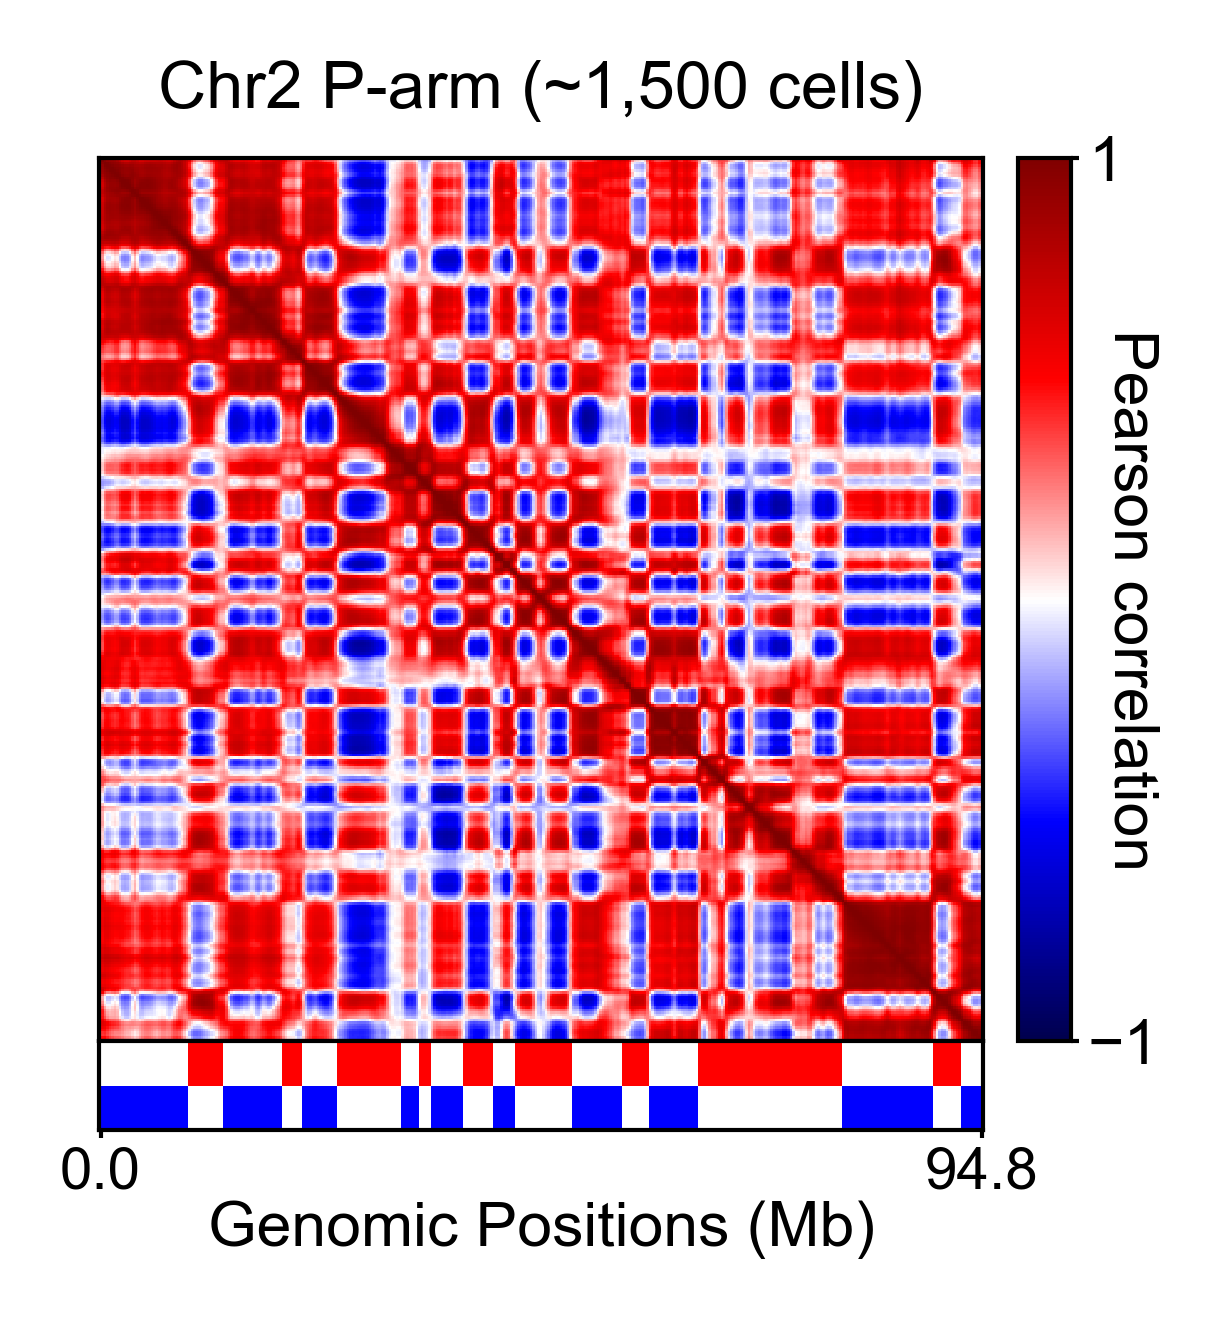

In [39]:
lims = [0,len(p_contact_corr_rep1_map)]

xlims = np.array([min(lims), max(lims)])
ylims = np.array([min(lims), max(lims)])

from mpl_toolkits.axes_grid1 import make_axes_locatable

domain_line_color = [1,1,0,1]
domain_line_width = 1.5
bad_color=[0,0,0,1]

fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)

# create a color map
current_cmap = matplotlib.cm.get_cmap('seismic')
current_cmap.set_bad(color=[0.5,0.5,0.5,1])

_pf = ax1.imshow(p_contact_corr_rep1_map, cmap=current_cmap, vmin=-1, vmax=1)

ax1.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]


# locate ax1
divider = make_axes_locatable(ax1)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1, ticks=[-1,1])
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Pearson correlation', 
               fontsize=_font_size, labelpad=0, rotation=270)

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", 
                             sharex=ax1, xticks=[])
bot_ax.bar(data_rep1['p_AB_dict']['A'], height=1, color='r', width=1, label='A')
bot_ax.bar(data_rep1['p_AB_dict']['B'], height=-1, color='b', width=1, label='B')
bot_ax.set_yticks([])
bot_ax.set_yticklabels([])
bot_ax.set_ylim([-1,1])

_xticks = [0, len(p_contact_corr_rep1_map)-1]
bot_ax.set_xticks(_xticks)
bot_ax.set_xticklabels(np.round(genomic_positions_Mb[_xticks],1))
# tick params
bot_ax.tick_params('both', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in bot_ax.spines.items()]
# set labels
bot_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=0)

# set limits
bot_ax.set_xlim(xlims-0.5)
#left_ax.set_ylim([max(ylims)-0.5, min(ylims)-0.5])

ax1.set_title(f"Chr2 P-arm (~1,500 cells)", fontsize=_font_size+0.5)

# save
plt.gcf().subplots_adjust(bottom=0.15, left=0.16, right=0.88)

plt.savefig(os.path.join(figure_folder, f'Fig2D1_chr2_p_arm_contact_corr_rep1.pdf'), transparent=True)

plt.show()

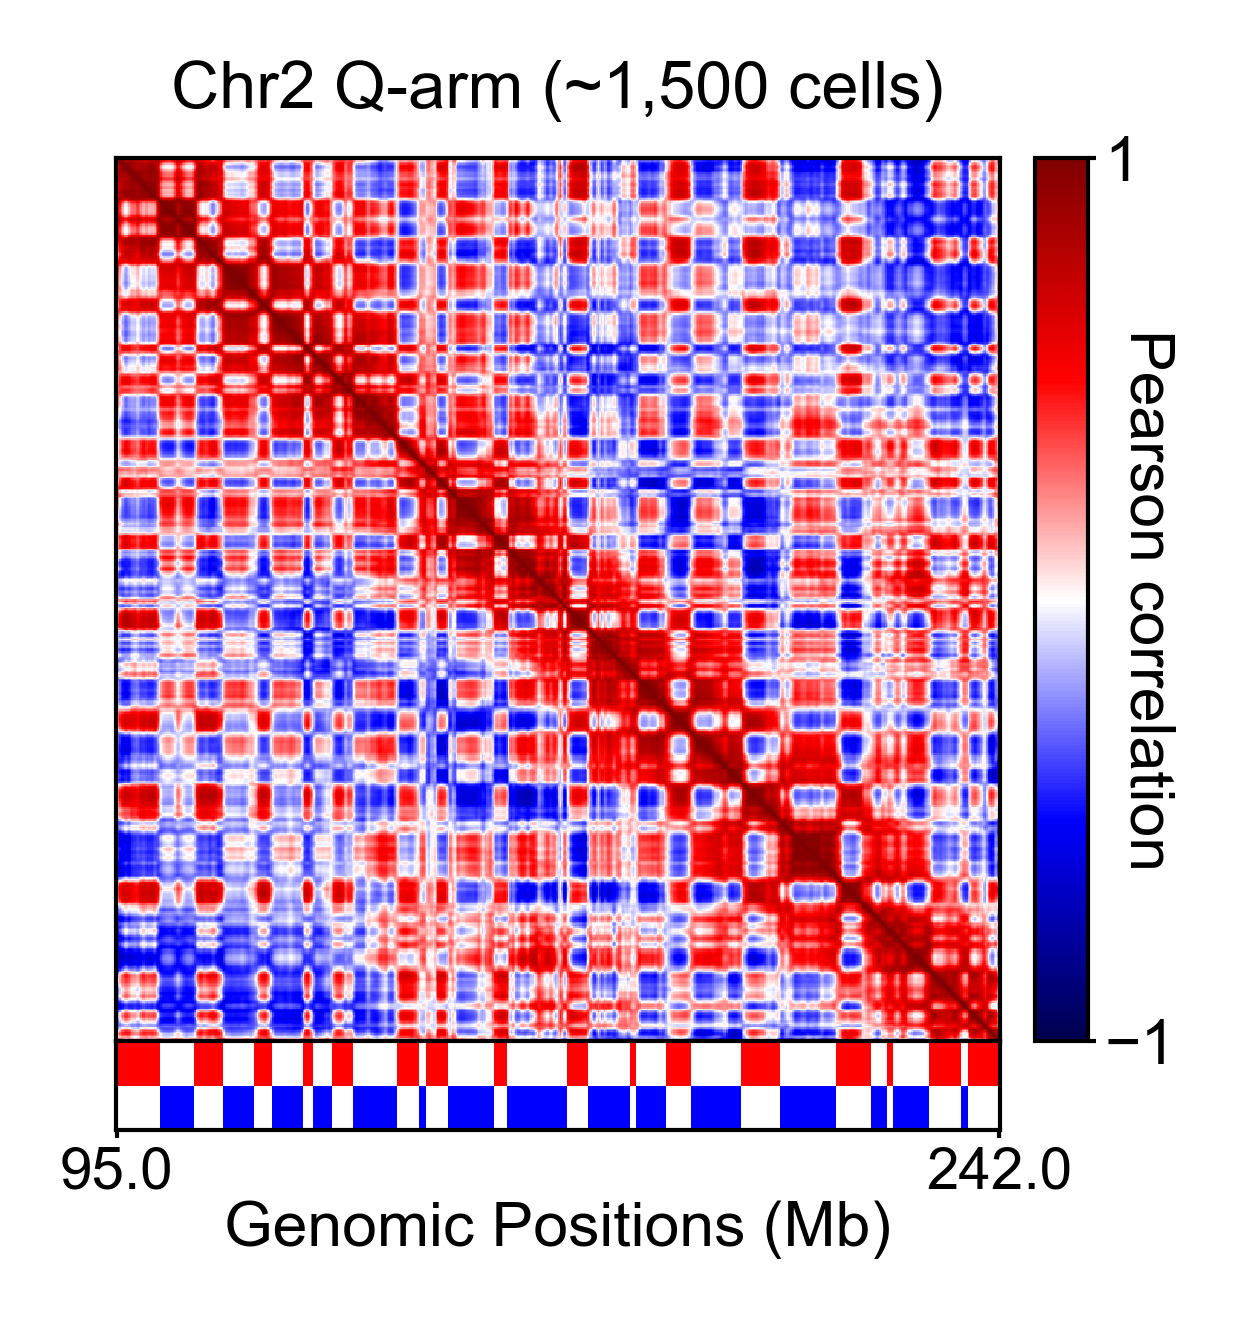

In [40]:
lims = [0,len(q_contact_corr_rep1_map)]

xlims = np.array([min(lims), max(lims)])
ylims = np.array([min(lims), max(lims)])

from mpl_toolkits.axes_grid1 import make_axes_locatable

domain_line_color = [1,1,0,1]
domain_line_width = 1.5
bad_color=[0,0,0,1]

fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)

# create a color map
current_cmap = matplotlib.cm.get_cmap('seismic')
current_cmap.set_bad(color=[0.5,0.5,0.5,1])

_pf = ax1.imshow(q_contact_corr_rep1_map, cmap=current_cmap, vmin=-1, vmax=1)

ax1.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]


# locate ax1
divider = make_axes_locatable(ax1)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1, ticks=[-1,1])
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Pearson correlation', 
               fontsize=_font_size, labelpad=0, rotation=270)

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", 
                             sharex=ax1, xticks=[])
bot_ax.bar(data_rep1['q_AB_dict']['A']-q_crop.start, height=1, color='r', width=1, label='A')
bot_ax.bar(data_rep1['q_AB_dict']['B']-q_crop.start, height=-1, color='b', width=1, label='B')
bot_ax.set_yticks([])
bot_ax.set_yticklabels([])
bot_ax.set_ylim([-1,1])

_xticks = [0, len(q_contact_corr_rep1_map)-1]
bot_ax.set_xticks(_xticks)
bot_ax.set_xticklabels(np.round(genomic_positions_Mb[q_crop][_xticks],1))
# tick params
bot_ax.tick_params('both', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in bot_ax.spines.items()]
# set labels
bot_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=0)

# set limits
bot_ax.set_xlim(xlims-0.5)
#left_ax.set_ylim([max(ylims)-0.5, min(ylims)-0.5])

ax1.set_title(f"Chr2 Q-arm (~1,500 cells)", fontsize=_font_size+0.5)

# save
plt.gcf().subplots_adjust(bottom=0.15, left=0.16, right=0.88)

plt.savefig(os.path.join(figure_folder, f'Fig2D2_chr2_q_arm_contact_corr_rep1.pdf'), transparent=True)

plt.show()

## 0.3 density scores

In [43]:
# density for the entire chr
import multiprocessing as mp
num_threads=32
density_var = 125 # nm

_dna_density_args = [(_zxys,_zxys, data_rep1['AB_dict'], [density_var,density_var,density_var], True) 
                     for _zxys in data_rep1['zxy']]
_dna_density_time = time.time()

print(f"Multiprocessing calculate dna_density_scores", end=' ')
if 'dna_density_scores' not in data_rep1:
    with mp.Pool(num_threads) as dna_density_pool:
        dna_density_dicts = dna_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _dna_density_args)
        dna_density_pool.close()
        dna_density_pool.join()
        dna_density_pool.terminate()
    # save
    data_rep1['dna_density_scores'] = dna_density_dicts
print(f"in {time.time()-_dna_density_time:.3f}s.")

Multiprocessing calculate dna_density_scores in 29.970s.


## Fig S2G: mean A.B density scores

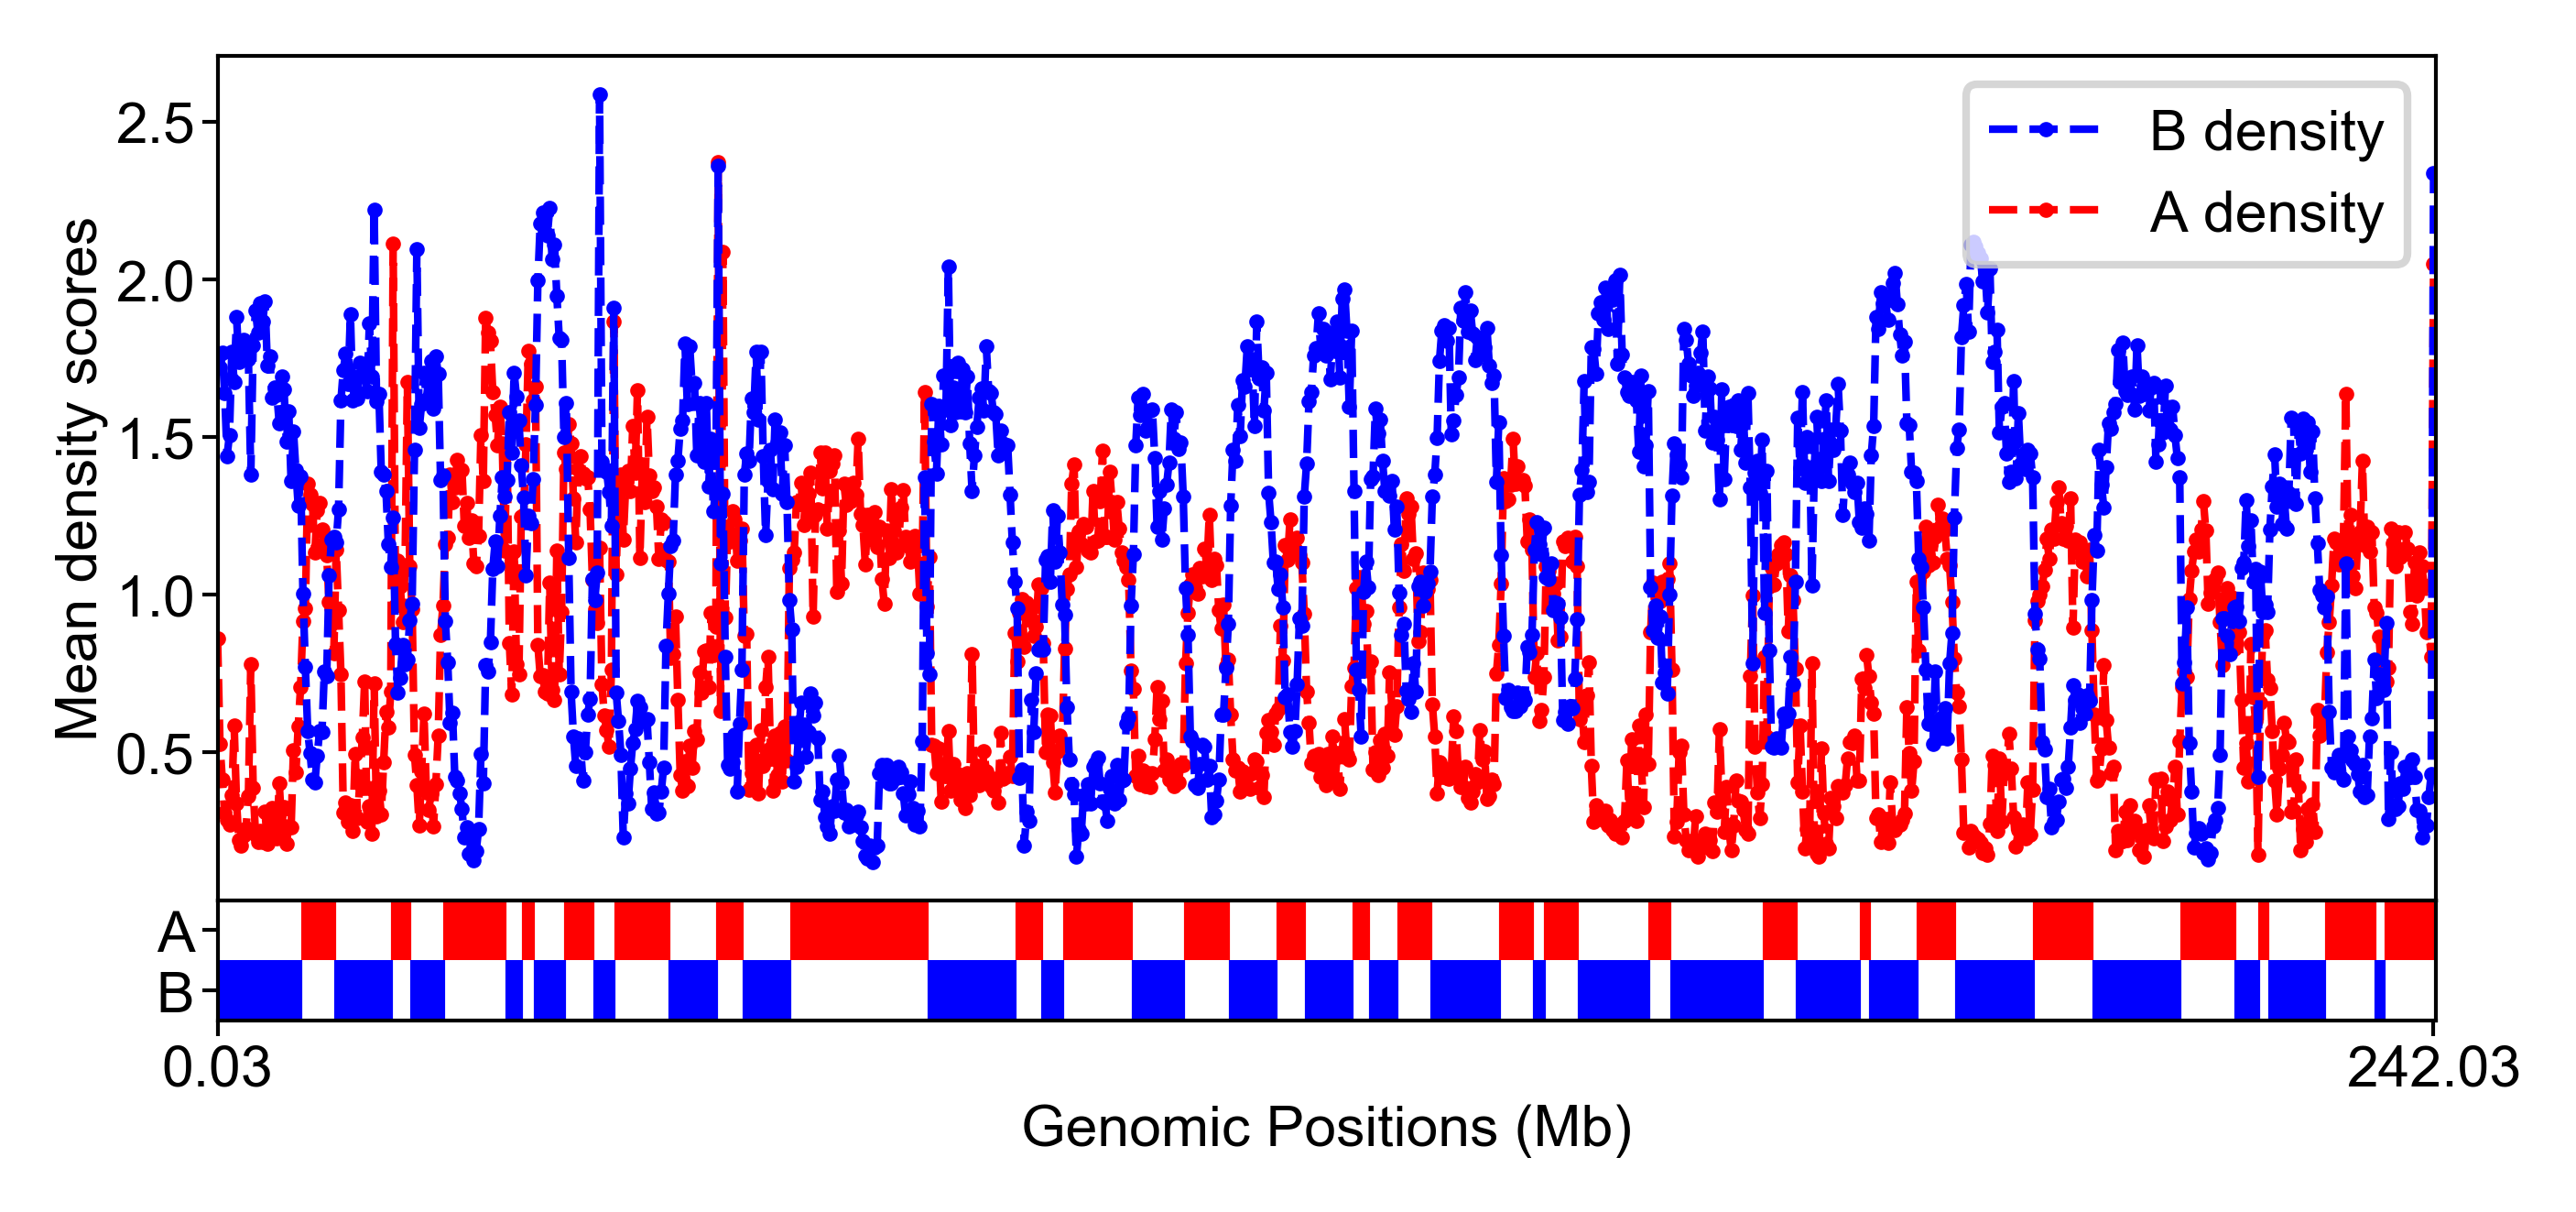

In [44]:
# Calculate mean A, B density
mean_A_scores = np.nanmedian([_s['A'] for _s in data_rep1['dna_density_scores']], axis=0)
mean_B_scores = np.nanmedian([_s['B'] for _s in data_rep1['dna_density_scores']], axis=0)

# Plot
fig = plt.figure(figsize=(_double_col_width, _single_col_width),dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[7,1], hspace=0., wspace=0.2)

main_ax = plt.subplot(grid[0], xticklabels=[])

main_ax.plot(mean_A_scores, 'r.--', label='A density', markersize=2, linewidth=1)
main_ax.plot(mean_B_scores, 'b.--', label='B density', markersize=2, linewidth=1)

# ticks
main_ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=False) # remove bottom ticklabels for ax1
main_ax.tick_params('x', length=0)
[i[1].set_linewidth(_ticklabel_width) for i in main_ax.spines.items()]
main_ax.set_ylabel(f"Mean density scores", fontsize=_font_size, labelpad=1)

handles, labels = main_ax.get_legend_handles_labels()
main_ax.legend(handles[::-1], labels[::-1], fontsize=_font_size, loc='upper right')
main_ax.set_xlim(0,len(mean_A_scores))

comp_ax = plt.subplot(grid[1], xticklabels=[], sharex=main_ax)
comp_ax.eventplot([data_rep1['AB_dict']['A'], data_rep1['AB_dict']['B']], lineoffsets=[0.5,-0.5],linelengths=1, linewidths=0.5,
                   colors=np.array([[1, 0, 0],[0, 0, 1]]))
#comp_ax.imshow(comp_vector[np.newaxis,:], cmap='seismic', vmin=-1, vmax=1)
comp_ax.tick_params('both', labelsize=_font_size, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in comp_ax.spines.items()]

comp_ax.set_yticks([0.5,-0.5])
comp_ax.set_yticklabels(["A","B"])
comp_ax.set_ylim([-1,1])
_xticks = [0, len(mean_A_scores)-1]
comp_ax.set_xticks(_xticks)
comp_ax.set_xticklabels(genomic_positions_Mb[_xticks])
comp_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.1, left=0.05)

plt.savefig(os.path.join(figure_folder, 'FigS2G_chr2_mean_AB_density_rep1.pdf'), transparent=True)

plt.show()

## 0.4 segregation score

In [46]:
def randomize_AB_dict(AB_dict):
    all_regs = np.sort(np.concatenate(list(AB_dict.values())))
    AB_identities = np.zeros(len(all_regs))
    AB_identities[np.array([_i for _i,_r in enumerate(all_regs) 
                            if _r in AB_dict['A']])] = 1
    # randomize new start
    new_start = np.random.randint(0, len(all_regs))
    new_AB_identities = np.concatenate([AB_identities[new_start:], AB_identities[:new_start]])
    # recreate AB_dict
    new_AB_dict = {'A': np.sort(all_regs[np.where(new_AB_identities==1)[0]]),
                   'B': np.sort(all_regs[np.where(new_AB_identities==0)[0]]),}
    return new_AB_dict

# calculate dynamic fraction scores
from scipy.stats import scoreatpercentile

AB_identities_rep1 = np.ones(len(data_rep1['zxy'][0])) * np.nan
AB_identities_rep1[data_rep1['AB_dict']['A']] = 1
AB_identities_rep1[data_rep1['AB_dict']['B']] = 0

from tqdm import tqdm
# calculate re-thresholded fraction scores
A_fracs, B_fracs = [], []
A_ths, B_ths = [], []
cloud_th_per=67
for _sd in tqdm(data_rep1['dna_density_scores']):
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][data_rep1['AB_dict']['A']], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][data_rep1['AB_dict']['B']], 100-cloud_th_per)
    # calculate purity within A,B clouds
    A_fracs.append(np.nanmean(AB_identities_rep1[np.where(_sd['A'] >= _A_th)[0]]))
    B_fracs.append(1-np.nanmean(AB_identities_rep1[np.where(_sd['B'] >= _B_th)[0]]))
    # store AB thresholds for references
    A_ths.append(_A_th)
    B_ths.append(_B_th)
# calculate re-thresholded fraction scores
rand_A_fracs, rand_B_fracs = [], []

for _sd in tqdm(data_rep1['dna_density_scores']):
    # randomize AB dict
    _rand_AB_dict = randomize_AB_dict(data_rep1['AB_dict'])
    _rand_A_inds, _rand_B_inds = np.array(_rand_AB_dict['A']), np.array(_rand_AB_dict['B'])
    # generate randomized AB_identities_rep1 vector for purity calculation
    _rand_AB_identities_rep1 = np.ones(len(data_rep1['zxy'][0])) * np.nan
    _rand_AB_identities_rep1[_rand_AB_dict['A']] = 1
    _rand_AB_identities_rep1[_rand_AB_dict['B']] = 0
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][_rand_A_inds], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][_rand_B_inds], 100-cloud_th_per)
    # calculate purity within A,B clouds
    rand_A_fracs.append(np.nanmean(_rand_AB_identities_rep1[np.where(_sd['A'] >= _A_th)[0]]))
    rand_B_fracs.append(1-np.nanmean(_rand_AB_identities_rep1[np.where(_sd['B'] >= _B_th)[0]]))

# Save
data_rep1['segregation_scores'] = (np.array(A_fracs) + np.array(B_fracs)) / 2
data_rep1['randomized_segregation_scores'] = (np.array(rand_A_fracs) + np.array(rand_B_fracs)) / 2

  0%|                                                                                         | 0/3066 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater_equal
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
  0%|                                                                                         | 0/3066 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater_equal
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater_equal
100%|█████████████████████████████████████████████████████████████████████████████| 3066/3066 [00:13<00:00, 231.15it/s]


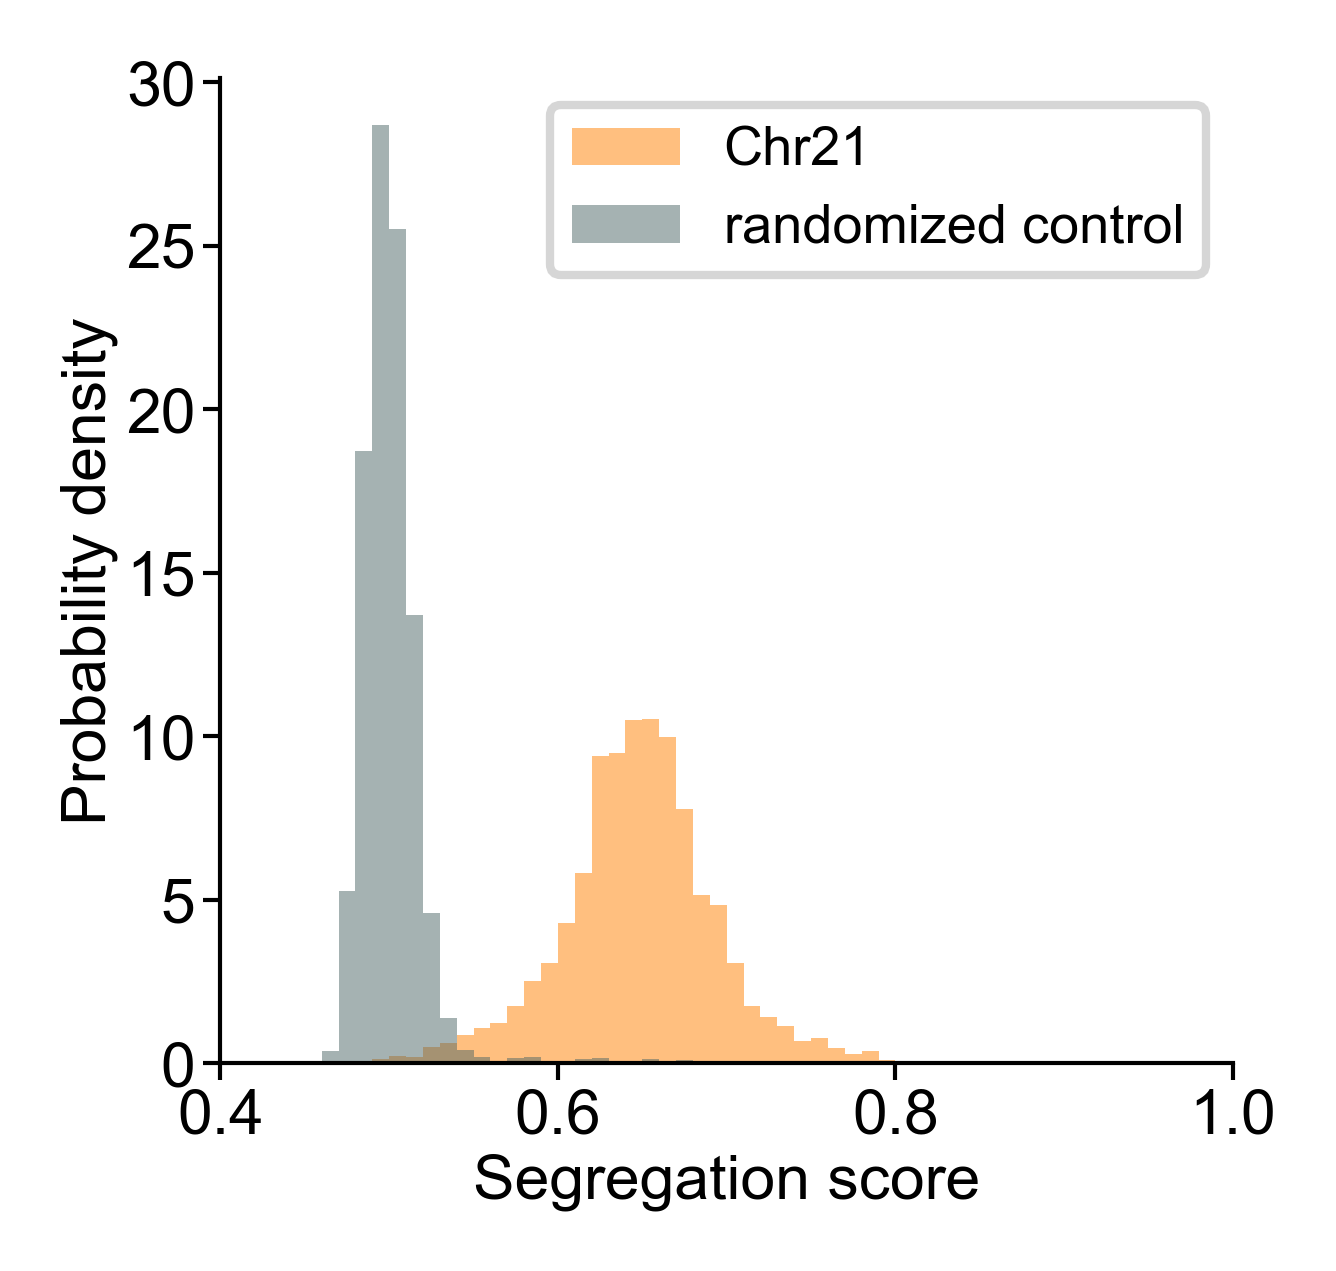

In [47]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)
ax.hist(data_rep1['segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[1,0.5,0], label='Chr21')
ax.hist(data_rep1['randomized_segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[0.3,0.4,0.4], label='randomized control')

ax.legend(fontsize=_font_size-1, loc='upper right')

ax.set_xlabel("Segregation score", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0.4,1])

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, 'Fig2F_chr2_segregation_hist_rep1.pdf'), transparent=True)
plt.show()

# From domain interaction to compartments

## 0.5 call domains for chr2

In [49]:
import source.domain_tools.DomainAnalysis as da
import multiprocessing as mp

num_threads=32
domain_corr_cutoff = 0.85 
domain_dist_cutoff = 1000 # nm

_domain_args = [(_zxys, 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _zxys in data_rep1['zxy']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
if 'domain_starts' not in data_rep1:
    with mp.Pool(num_threads) as domain_pool:
        domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
        domain_pool.close()
        domain_pool.join()
        domain_pool.terminate()
    # save
    data_rep1['domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
    #data_rep1['params']['domain_corr_cutoff'] = domain_corr_cutoff
    #data_rep1['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts 

KeyError: 'params'

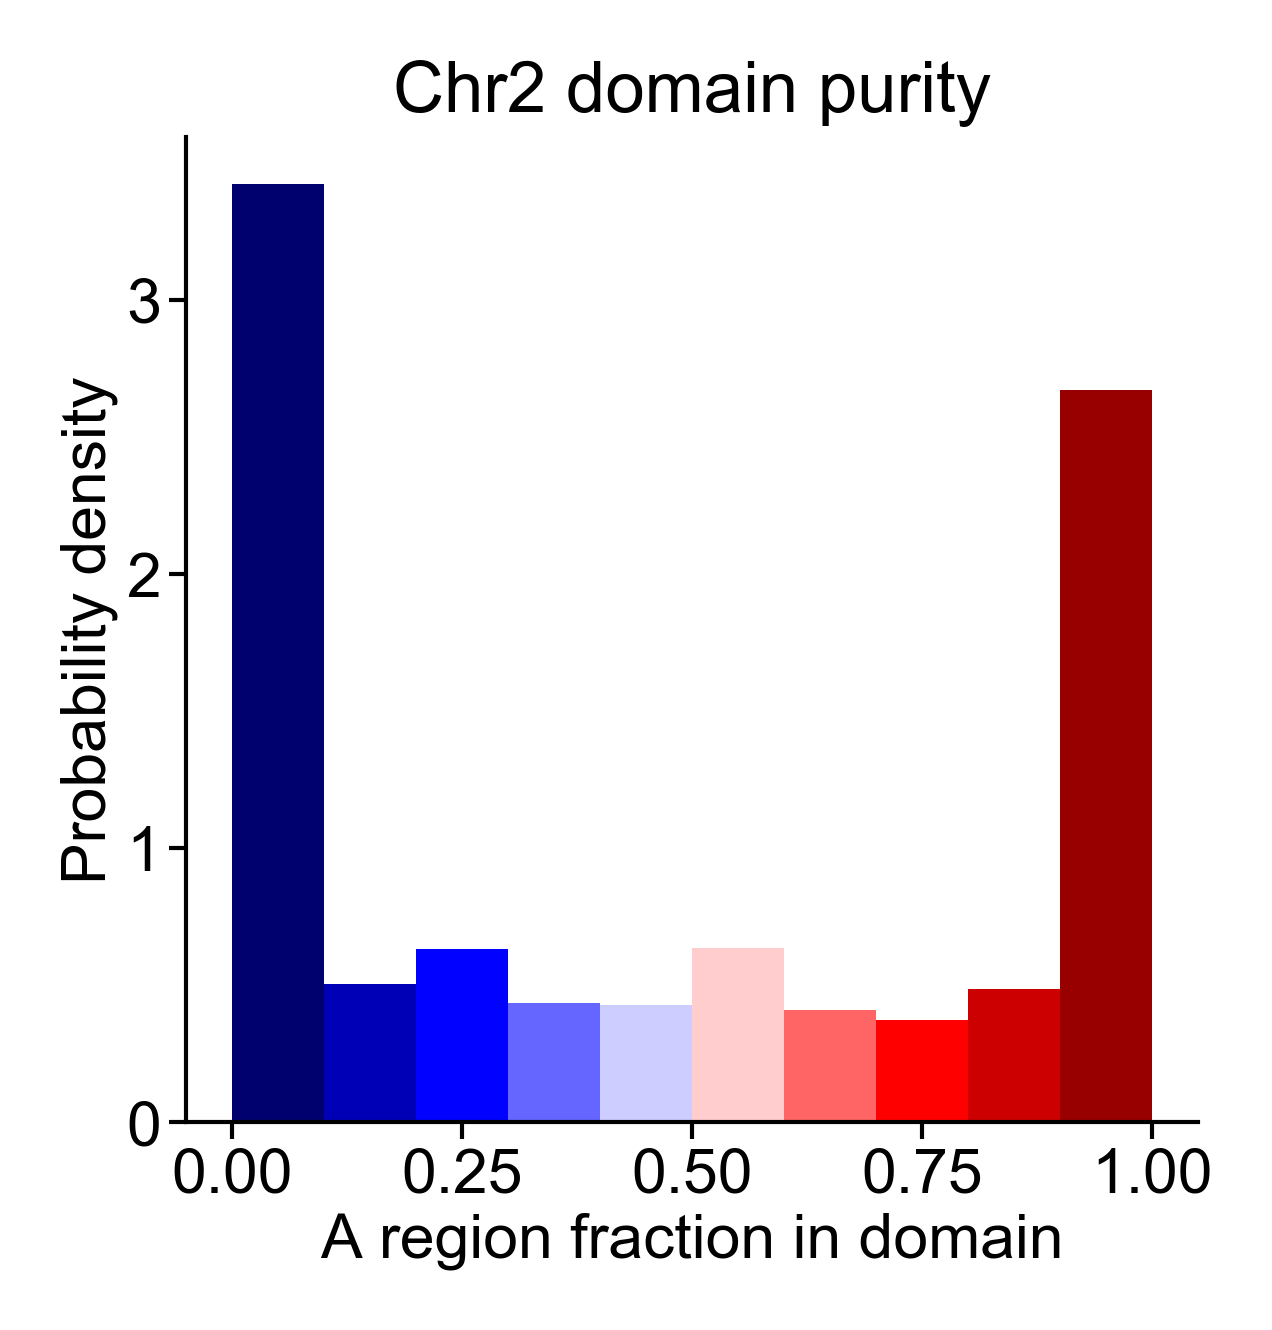

In [51]:
## purity histogram and normalized ones
_purity_bins = np.linspace(0,1,11)
_purity_bin_centers = (_purity_bins[1:] + _purity_bins[:-1])/2

AB_identities_rep1 = np.ones(len(data_rep1['zxy'][0])) * np.nan
AB_identities_rep1[data_rep1['AB_dict']['A']] = 1
AB_identities_rep1[data_rep1['AB_dict']['B']] = 0

# calculate purity for p-arm
purity_rep1_list = []

for _dms in data_rep1['domain_starts']:
    _dm_starts = _dms[:-1]
    _dm_ends = _dms[1:]
    _purities = [np.mean(AB_identities_rep1[_s:_e]) for _s, _e in zip(_dm_starts, _dm_ends)]
    purity_rep1_list.append(np.array(_purities))
    
cmap = matplotlib.cm.seismic
bin_colors = cmap(_purity_bin_centers)
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

hist_alpha = 1

n, hbins, hpatches = ax.hist(np.concatenate(purity_rep1_list), bins=_purity_bins, 
                             alpha=hist_alpha, density=True, label='total')

for _color, _p in zip(bin_colors, hpatches):
    plt.setp(_p, 'facecolor', _color)

#hab = ax.hist(ama_AB, 24, range=(0,0.6), color='grey', alpha=hist_alpha, density=True, label='AB')
#hbb = ax.hist(ama_BB, 24, range=(0,0.6), color='b', alpha=hist_alpha, density=True, label='BB')

ax.set_xlabel("A region fraction in domain", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.legend(fontsize=_font_size, framealpha=1, loc='upper right')
ax.set_title(f"Chr2 domain purity", pad=3, fontsize=_font_size+1)
    
plt.gcf().subplots_adjust(left=0.15, bottom=0.15)
# save
plt.savefig(os.path.join(figure_folder, 'Fig3C_histogram_purity_rep1.pdf'), transparent=True)
plt.show()

## 0.6: domain interaction calling

In [52]:
from importlib import reload
reload(ia.domain_tools.interaction)

<module 'source.domain_tools.interaction' from 'E:\\Users\\puzheng\\Documents\\Chromatin_Tracing_Analysis\\sequential_tracing\\source\\domain_tools\\interaction.py'>

In [55]:
import multiprocessing as mp
num_threads=32
# cutoff for:
#  domain pairs touching each other -> insulation score <= 2
#  domain pairs fully intermix with each other -> insulation score <= 1
domain_interact_cutoff = 2
domain_intermix_cutoff = 1

cutoffs = [domain_intermix_cutoff,domain_interact_cutoff]

rep1_interdomain_list = []

for _cutoff in cutoffs:
    _dom_contact_args = [(_zxys, _domain_starts, _cutoff) 
                    for _zxys, _domain_starts in zip(data_rep1['zxy'],data_rep1['domain_starts'])]
    _domain_time = time.time()

    print(f"Multiprocessing call domain contacts", end=' ')
    with mp.Pool(num_threads) as dom_contact_pool:
        dom_contact_results = dom_contact_pool.starmap(ia.domain_tools.interaction.call_domain_contact, _dom_contact_args)
        dom_contact_pool.close()
        dom_contact_pool.join()
        dom_contact_pool.terminate()
    rep1_interdomain_list.append(dom_contact_results)
    
    print(f"in {time.time()-_domain_time:.3f}s.")
    

Multiprocessing call domain contacts in 70.765s.
Multiprocessing call domain contacts in 72.764s.


In [57]:
AB_identities_rep1 = np.ones(len(data_rep1['zxy'][0])) * np.nan
AB_identities_rep1[data_rep1['AB_dict']['A']] = 1
AB_identities_rep1[data_rep1['AB_dict']['B']] = 0

from tqdm import tqdm_notebook as tqdm
# calculate purity and gdists between each pairs
rep1_purity_cutoff_list = []
rep1_gdist_cutoff_list = []

for _cutoff, _interdomain_list in zip(cutoffs, rep1_interdomain_list):
    print(f"insulation threshold: {_cutoff}")
    pair_purities = []
    pair_gdists = []
    
    for _chrom_id, (_dms, _pairs) in tqdm(enumerate(zip(data_rep1['domain_starts'], _interdomain_list))):
        _dm_starts = _dms[:-1]
        _dm_ends = _dms[1:]
        _purities = [np.mean(AB_identities_rep1[_s:_e]) for _s, _e in zip(_dm_starts, _dm_ends)]
        # pairs called in interdomain
        for _p in _pairs:
            if _p[0] > _p[1]:
                _dm_gdist = genomic_dist_mat[int((_dm_starts[_p[0]]+_dm_ends[_p[0]])/2),
                                             int((_dm_starts[_p[1]]+_dm_ends[_p[1]])/2)]
                _dm_purites = np.array([_purities[_p[0]], _purities[_p[1]]])

                # append
                pair_purities.append(_dm_purites)
                pair_gdists.append(_dm_gdist)
                
    rep1_purity_cutoff_list.append(np.array(pair_purities))
    rep1_gdist_cutoff_list.append(np.array(pair_gdists))

    
# calculate purity and gdists between all domain candidate pairs, as the denominator
rep1_all_purity_pairs = []
rep1_all_gdists = []

for _chrom_id, _dms in tqdm(enumerate(data_rep1['domain_starts'])):
    _dm_starts = _dms[:-1]
    _dm_ends = _dms[1:]
    _purities = [np.mean(AB_identities_rep1[_s:_e]) for _s, _e in zip(_dm_starts, _dm_ends)]
    for _i, (_si, _ei) in enumerate(zip(_dm_starts, _dm_ends)):
        for _j, (_sj, _ej) in enumerate(zip(_dm_starts[:_i], _dm_ends[:_i])):
            _dm_gdist = genomic_dist_mat[int((_si+_ei)/2),
                                         int((_sj+_ej)/2)]
            _dm_purites = np.array([_purities[_i], _purities[_j]])
            # append
            rep1_all_purity_pairs.append(_dm_purites)
            rep1_all_gdists.append(_dm_gdist)
            
rep1_all_purity_pairs = np.array(rep1_all_purity_pairs)
rep1_all_gdists = np.array(rep1_all_gdists)

insulation threshold: 1



insulation threshold: 2


## Fig3E: domain interaction freqeuncy given purity

In [58]:
## purity histogram and normalized ones
_purity_bins = np.linspace(0,1,11)
_purity_bin_centers = (_purity_bins[1:] + _purity_bins[:-1])/2


rep1_purity_count_mat = np.zeros([len(_purity_bin_centers),
                                    len(_purity_bin_centers)])
# get cutoff=2 case
_purity_list = rep1_purity_cutoff_list[-1]
_gdist_list = rep1_gdist_cutoff_list[-1]
for _pair, _gd in tqdm(zip(_purity_list, _gdist_list)):
    _p, _q = _pair
    _p_ind = np.where((_p >= _purity_bins[:-1]) & (_p <= _purity_bins[1:]))[0][0]
    _q_ind = np.where((_q >= _purity_bins[:-1]) & (_q <= _purity_bins[1:]))[0][0]
   #print(_p_ind)
    #if _gd <= gd_cutoff:
    rep1_purity_count_mat[_p_ind,_q_ind] += 1
    rep1_purity_count_mat[_q_ind,_p_ind] += 1
    
rep1_all_purity_count_mat = np.zeros([len(_purity_bin_centers),
                                        len(_purity_bin_centers)])
for _pair, _gd in tqdm(zip(rep1_all_purity_pairs, rep1_all_gdists)):
    _p, _q = _pair
    _p_ind = np.where((_p >= _purity_bins[:-1]) & (_p <= _purity_bins[1:]))[0][0]
    _q_ind = np.where((_q >= _purity_bins[:-1]) & (_q <= _purity_bins[1:]))[0][0]
    #print(_p_ind)
    #if _gd <= gd_cutoff:
    rep1_all_purity_count_mat[_p_ind,_q_ind] += 1
    rep1_all_purity_count_mat[_q_ind,_p_ind] += 1

# calculate this probability matrix
rep1_purity_prob_mat = rep1_purity_count_mat / rep1_all_purity_count_mat

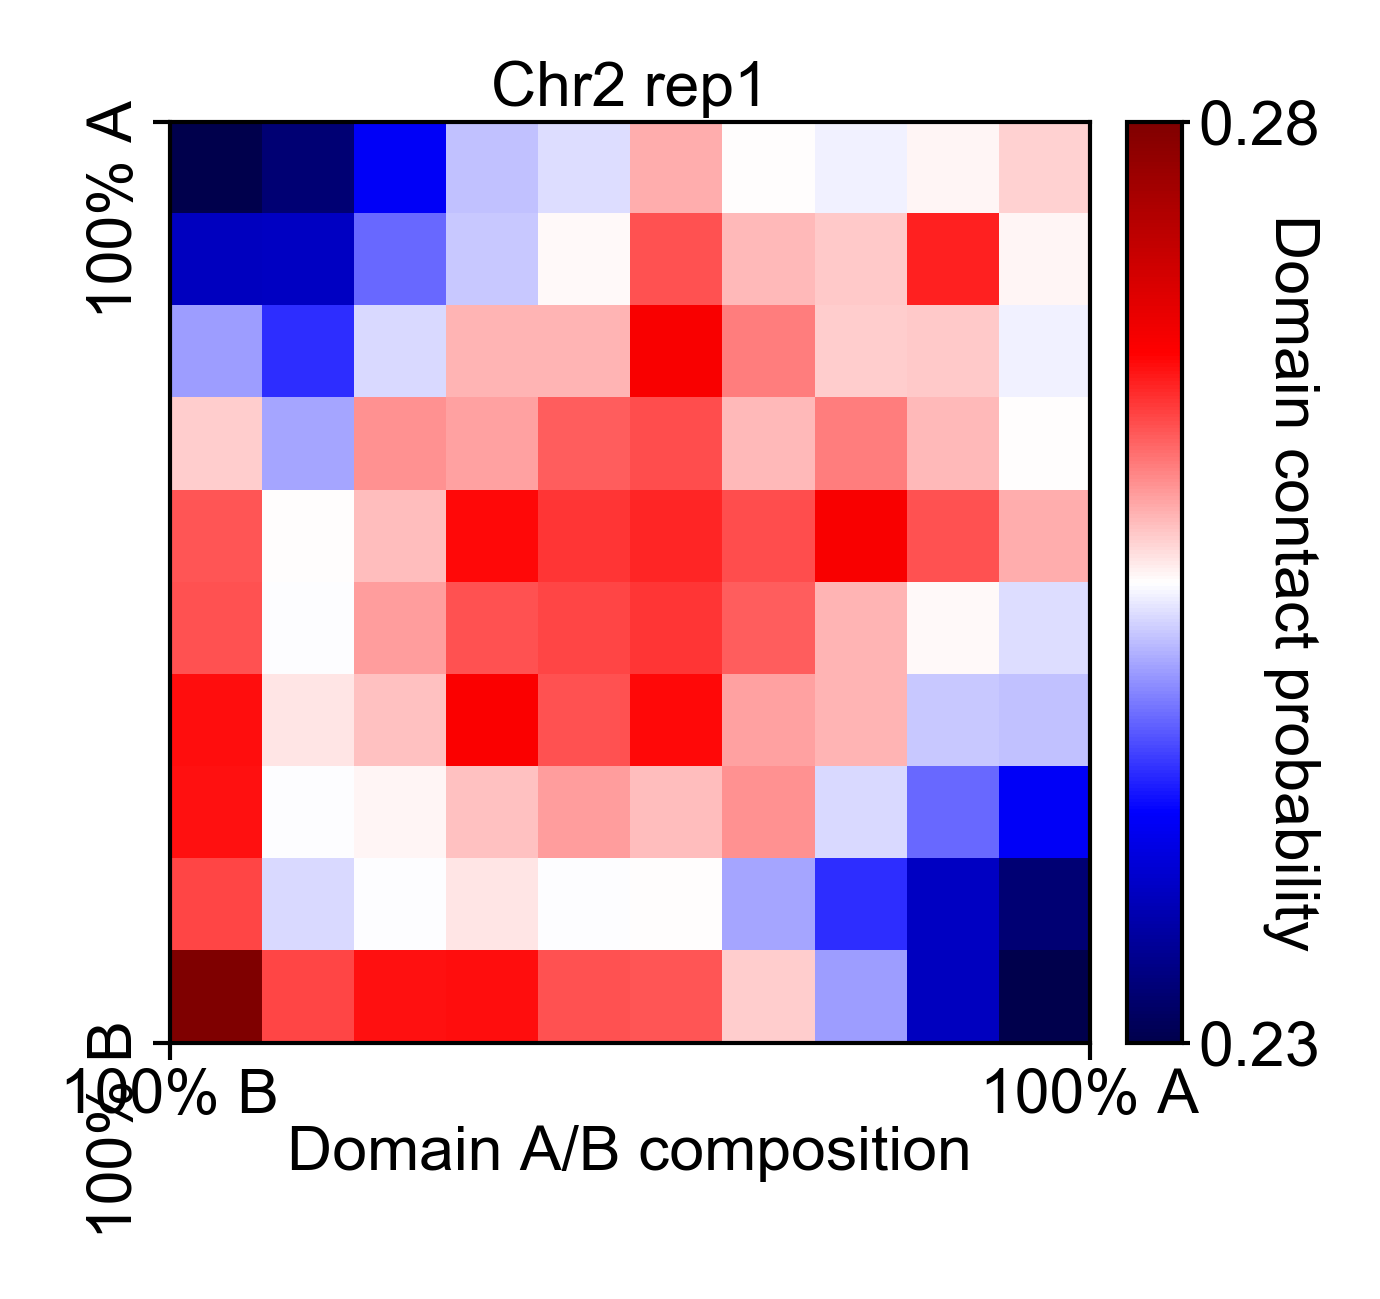

In [59]:
color_limits = [0.23, 0.28]

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=_dpi)

_pf = ax.imshow(rep1_purity_prob_mat, cmap='seismic', interpolation='nearest',
                vmin=min(color_limits), vmax=max(color_limits))

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=True, labelleft=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

ax.set_title(f"Chr2 rep1", 
             fontsize=_font_size, pad=2)
# ticks
_xticks = [-0.5,9.5]
_xtick_labels = ['100% B', '100% A']

ax.set_ylim(_xticks)
ax.set_xlim(_xticks)

ax.set_xticks(_xticks)
ax.set_xticklabels(_xtick_labels)
ax.set_yticks(_xticks)
ax.set_yticklabels(_xtick_labels, rotation=90)

ax.set_xlabel('Domain A/B composition', labelpad=0, fontsize=_font_size)

# locate ax
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax, ticks=color_limits)
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Domain contact probability', fontsize=_font_size, 
               labelpad=0, rotation=270)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1, right=0.85)

plt.savefig(os.path.join(figure_folder, f'Fig3E_chr2_contact_prob_given_purity_rep1.pdf'), transparent=True)

plt.show()

## Fig3G: domain interaction freqeuncy given purity and long genomic distances

In [60]:
gd_cutoff = 80 # Mb

## purity histogram and normalized ones
_purity_bins = np.linspace(0,1,11)
_purity_bin_centers = (_purity_bins[1:] + _purity_bins[:-1])/2


rep1_purity_high_gd_count_mat = np.zeros([len(_purity_bin_centers),
                                    len(_purity_bin_centers)])
# get cutoff=2 case
_purity_list = rep1_purity_cutoff_list[-1]
_gdist_list = rep1_gdist_cutoff_list[-1]
for _pair, _gd in tqdm(zip(_purity_list, _gdist_list)):
    _p, _q = _pair
    _p_ind = np.where((_p >= _purity_bins[:-1]) & (_p <= _purity_bins[1:]))[0][0]
    _q_ind = np.where((_q >= _purity_bins[:-1]) & (_q <= _purity_bins[1:]))[0][0]
    if _gd > gd_cutoff:
        rep1_purity_high_gd_count_mat[_p_ind,_q_ind] += 1
        rep1_purity_high_gd_count_mat[_q_ind,_p_ind] += 1
    
rep1_all_purity_high_gd_count_mat = np.zeros([len(_purity_bin_centers),
                                        len(_purity_bin_centers)])
for _pair, _gd in tqdm(zip(rep1_all_purity_pairs, rep1_all_gdists)):
    _p, _q = _pair
    _p_ind = np.where((_p >= _purity_bins[:-1]) & (_p <= _purity_bins[1:]))[0][0]
    _q_ind = np.where((_q >= _purity_bins[:-1]) & (_q <= _purity_bins[1:]))[0][0]
    
    if _gd > gd_cutoff:
        rep1_all_purity_high_gd_count_mat[_p_ind,_q_ind] += 1
        rep1_all_purity_high_gd_count_mat[_q_ind,_p_ind] += 1

# calculate this probability matrix
rep1_purity_high_gd_prob_mat = rep1_purity_high_gd_count_mat / rep1_all_purity_high_gd_count_mat

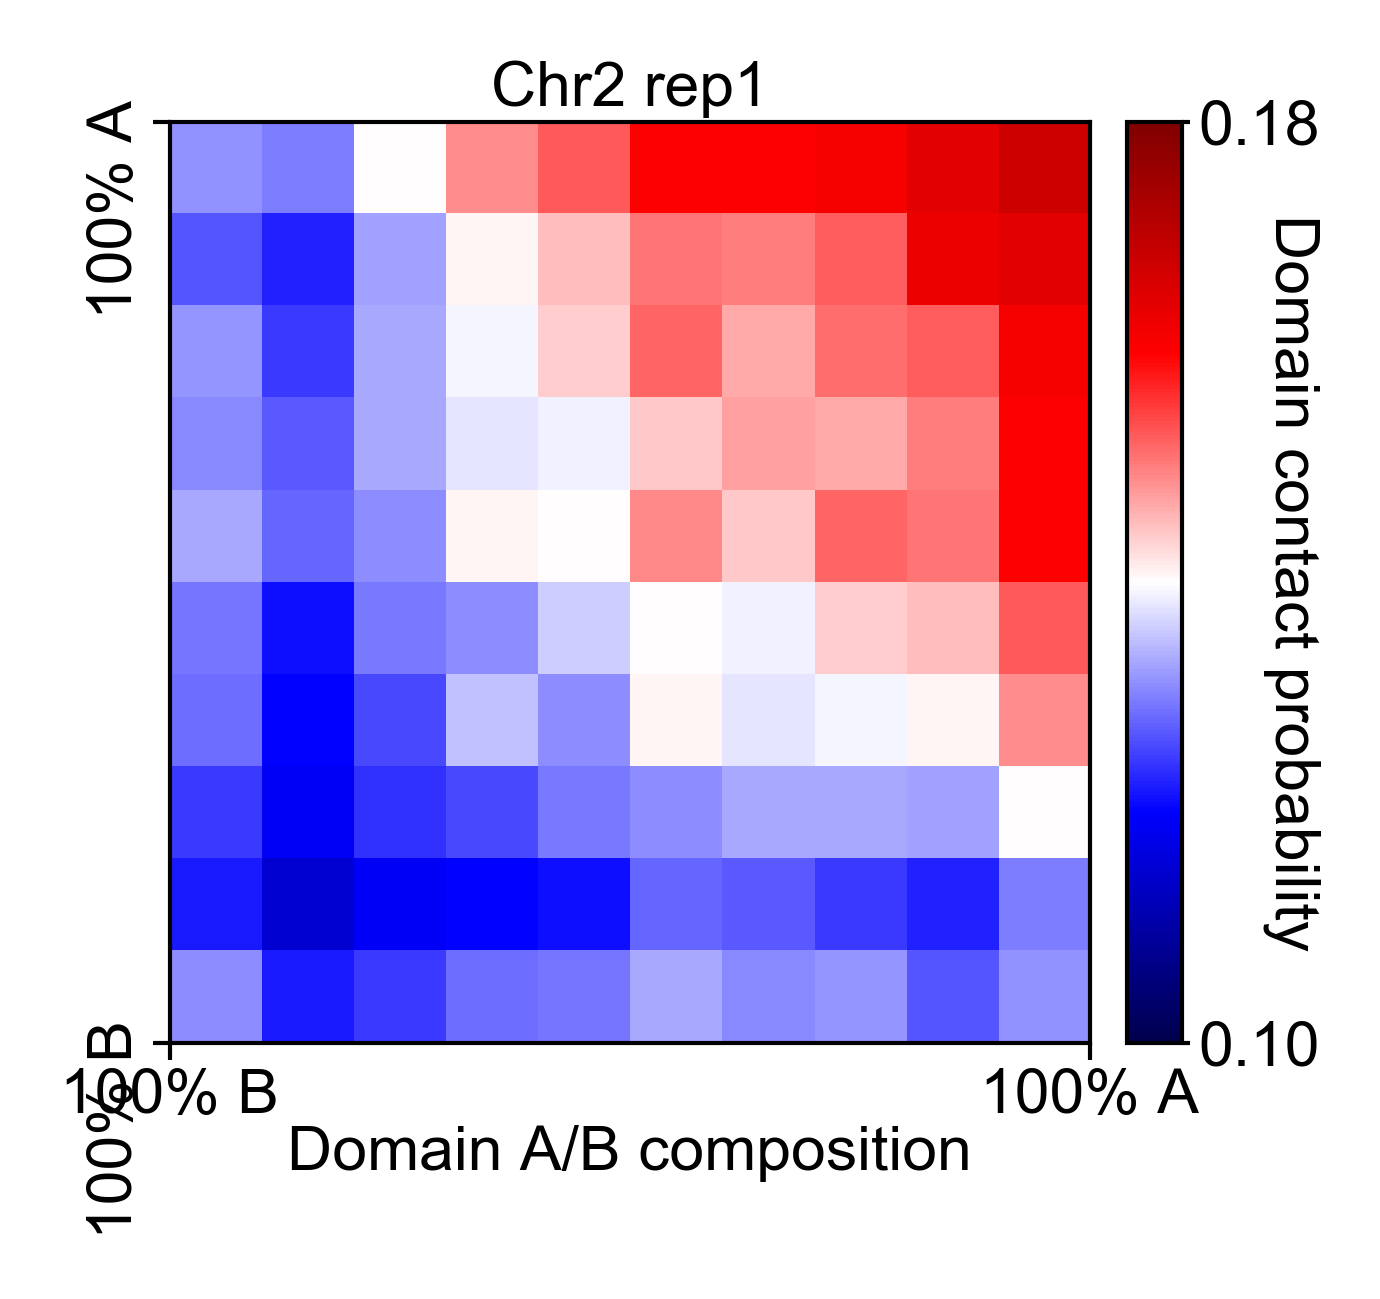

In [61]:
color_limits = [0.1, 0.18]

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=_dpi)

_pf = ax.imshow(rep1_purity_high_gd_prob_mat, cmap='seismic', interpolation='nearest',
                vmin=min(color_limits), vmax=max(color_limits))

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=True, labelleft=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

ax.set_title(f"Chr2 rep1", 
             fontsize=_font_size, pad=2)
# ticks
_xticks = [-0.5,9.5]
_xtick_labels = ['100% B', '100% A']

ax.set_ylim(_xticks)
ax.set_xlim(_xticks)

ax.set_xticks(_xticks)
ax.set_xticklabels(_xtick_labels)
ax.set_yticks(_xticks)
ax.set_yticklabels(_xtick_labels, rotation=90)

ax.set_xlabel('Domain A/B composition', labelpad=0, fontsize=_font_size)

# locate ax
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax, ticks=color_limits)
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Domain contact probability', fontsize=_font_size, 
               labelpad=0, rotation=270)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1, right=0.85)

plt.savefig(os.path.join(figure_folder, f'Fig3G_chr2_contact_prob_given_purity_high_gd_rep1.pdf'), transparent=True)

plt.show()

## Fig3F: domain contact probability given genomic distance

2


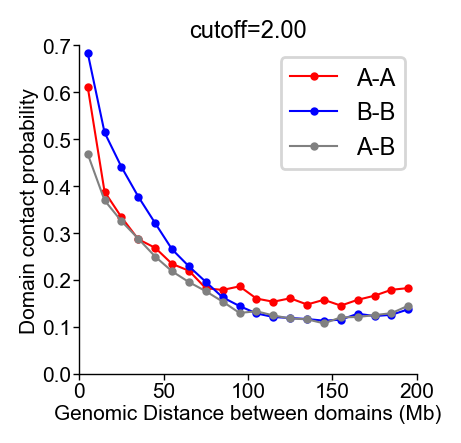

In [62]:
num_bins = 20
p_genomic_dist_mat = genomic_dist_mat[p_crop, p_crop]
_bins = np.linspace(np.min(p_genomic_dist_mat), 
                    #np.max(p_genomic_dist_mat), 
                    200,
                    num_bins+1)
_bin_centers = (_bins[:-1] + _bins[1:]) / 2
A_th = 0.9
B_th = 0.1

# Fig3F: cutoff = 2
_cutoff =  2
_index = cutoffs.index(_cutoff)
_gdists = rep1_gdist_cutoff_list[_index]
_purity_pairs = rep1_purity_cutoff_list[_index]


print(_cutoff)
nBB,_ = np.histogram(_gdists[(_purity_pairs[:,0]<B_th)&(_purity_pairs[:,1]<B_th)],bins=_bins)
nAA,_ = np.histogram(_gdists[(_purity_pairs[:,0]>A_th)&(_purity_pairs[:,1]>A_th)],bins=_bins)
nBB_all,_ = np.histogram(rep1_all_gdists[(rep1_all_purity_pairs[:,0]<B_th)&(rep1_all_purity_pairs[:,1]<B_th)],bins=_bins)
nAA_all,_ = np.histogram(rep1_all_gdists[(rep1_all_purity_pairs[:,0]>A_th)&(rep1_all_purity_pairs[:,1]>A_th)],bins=_bins)
nAB,_ = np.histogram(_gdists[(_purity_pairs[:,0]<B_th)&(_purity_pairs[:,1]>A_th) \
                             | (_purity_pairs[:,0]>A_th)&(_purity_pairs[:,1]<B_th)],bins=_bins)
nAB_all,_ = np.histogram(rep1_all_gdists[(rep1_all_purity_pairs[:,0]>A_th)&(rep1_all_purity_pairs[:,1]<B_th) \
                                    | (rep1_all_purity_pairs[:,0]<B_th)&(rep1_all_purity_pairs[:,1]>A_th)],bins=_bins)

fig, ax = plt.subplots(dpi=200, figsize=(_single_col_width, _single_col_width))
_line_AA = ax.plot(_bin_centers,nAA/nAA_all,'-o', linewidth=0.75, markersize=2, color='r', label='A-A')
_line_BB = ax.plot(_bin_centers,nBB/nBB_all,'-o', linewidth=0.75, markersize=2, color='b', label='B-B')
_line_AB = ax.plot(_bin_centers,nAB/nAB_all,'-o', linewidth=0.75, markersize=2, color='grey', label='A-B')

ax.tick_params('both', labelsize=_font_size, 
        width=_ticklabel_width, length=_ticklabel_size,
        pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0, np.max(_bins)])
ax.set_ylim([0., 0.7])

ax.set_xlabel(f"Genomic Distance between domains (Mb)", labelpad=1, fontsize=_font_size)
ax.set_ylabel(f"Domain contact probability", labelpad=1, fontsize=_font_size)
ax.set_title(f"cutoff={_cutoff:.2f}", pad=3, fontsize=_font_size+1)

ax.legend(loc='upper right',fontsize=_font_size+1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, f"Fig3F_chr2_insulation_genomic_{_cutoff:.2f}_rep1.pdf"), transparent=True)
plt.show()

1


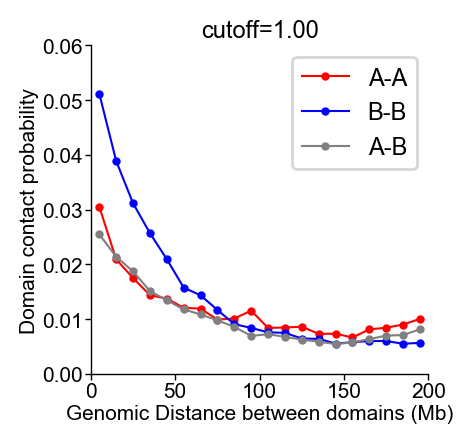

In [63]:
# Fig3H: cutoff = 1
_cutoff =  1
_index = cutoffs.index(_cutoff)
_gdists = rep1_gdist_cutoff_list[_index]
_purity_pairs = rep1_purity_cutoff_list[_index]


print(_cutoff)
nBB,_ = np.histogram(_gdists[(_purity_pairs[:,0]<B_th)&(_purity_pairs[:,1]<B_th)],bins=_bins)
nAA,_ = np.histogram(_gdists[(_purity_pairs[:,0]>A_th)&(_purity_pairs[:,1]>A_th)],bins=_bins)
nBB_all,_ = np.histogram(rep1_all_gdists[(rep1_all_purity_pairs[:,0]<B_th)&(rep1_all_purity_pairs[:,1]<B_th)],bins=_bins)
nAA_all,_ = np.histogram(rep1_all_gdists[(rep1_all_purity_pairs[:,0]>A_th)&(rep1_all_purity_pairs[:,1]>A_th)],bins=_bins)
nAB,_ = np.histogram(_gdists[(_purity_pairs[:,0]<B_th)&(_purity_pairs[:,1]>A_th) \
                             | (_purity_pairs[:,0]>A_th)&(_purity_pairs[:,1]<B_th)],bins=_bins)
nAB_all,_ = np.histogram(rep1_all_gdists[(rep1_all_purity_pairs[:,0]>A_th)&(rep1_all_purity_pairs[:,1]<B_th) \
                                    | (rep1_all_purity_pairs[:,0]<B_th)&(rep1_all_purity_pairs[:,1]>A_th)],bins=_bins)

fig, ax = plt.subplots(dpi=200, figsize=(_single_col_width, _single_col_width))
_line_AA = ax.plot(_bin_centers,nAA/nAA_all,'-o', linewidth=0.75, markersize=2, color='r', label='A-A')
_line_BB = ax.plot(_bin_centers,nBB/nBB_all,'-o', linewidth=0.75, markersize=2, color='b', label='B-B')
_line_AB = ax.plot(_bin_centers,nAB/nAB_all,'-o', linewidth=0.75, markersize=2, color='grey', label='A-B')

ax.tick_params('both', labelsize=_font_size, 
        width=_ticklabel_width, length=_ticklabel_size,
        pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0, np.max(_bins)])
ax.set_ylim([0., 0.06])

ax.set_xlabel(f"Genomic Distance between domains (Mb)", labelpad=1, fontsize=_font_size)
ax.set_ylabel(f"Domain contact probability", labelpad=1, fontsize=_font_size)
ax.set_title(f"cutoff={_cutoff:.2f}", pad=3, fontsize=_font_size+1)

ax.legend(loc='upper right',fontsize=_font_size+1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, f"Fig3H_chr2_insulation_genomic_{_cutoff:.2f}_rep1.pdf"), transparent=True)
plt.show()

In [64]:
## Fig 3E with different binning
## purity histogram and normalized ones
_purity_bins = np.linspace(0,1,6)
_purity_bin_centers = (_purity_bins[1:] + _purity_bins[:-1])/2


rep1_purity_count_mat = np.zeros([len(_purity_bin_centers),
                                    len(_purity_bin_centers)])
# get cutoff=2 case
_purity_list = rep1_purity_cutoff_list[-1]
_gdist_list = rep1_gdist_cutoff_list[-1]
for _pair, _gd in tqdm(zip(_purity_list, _gdist_list)):
    _p, _q = _pair
    _p_ind = np.where((_p >= _purity_bins[:-1]) & (_p <= _purity_bins[1:]))[0][0]
    _q_ind = np.where((_q >= _purity_bins[:-1]) & (_q <= _purity_bins[1:]))[0][0]
   #print(_p_ind)
    #if _gd <= gd_cutoff:
    rep1_purity_count_mat[_p_ind,_q_ind] += 1
    rep1_purity_count_mat[_q_ind,_p_ind] += 1
    
rep1_all_purity_count_mat = np.zeros([len(_purity_bin_centers),
                                        len(_purity_bin_centers)])
for _pair, _gd in tqdm(zip(rep1_all_purity_pairs, rep1_all_gdists)):
    _p, _q = _pair
    _p_ind = np.where((_p >= _purity_bins[:-1]) & (_p <= _purity_bins[1:]))[0][0]
    _q_ind = np.where((_q >= _purity_bins[:-1]) & (_q <= _purity_bins[1:]))[0][0]
    #print(_p_ind)
    #if _gd <= gd_cutoff:
    rep1_all_purity_count_mat[_p_ind,_q_ind] += 1
    rep1_all_purity_count_mat[_q_ind,_p_ind] += 1

# calculate this probability matrix
rep1_purity_prob_mat = rep1_purity_count_mat / rep1_all_purity_count_mat

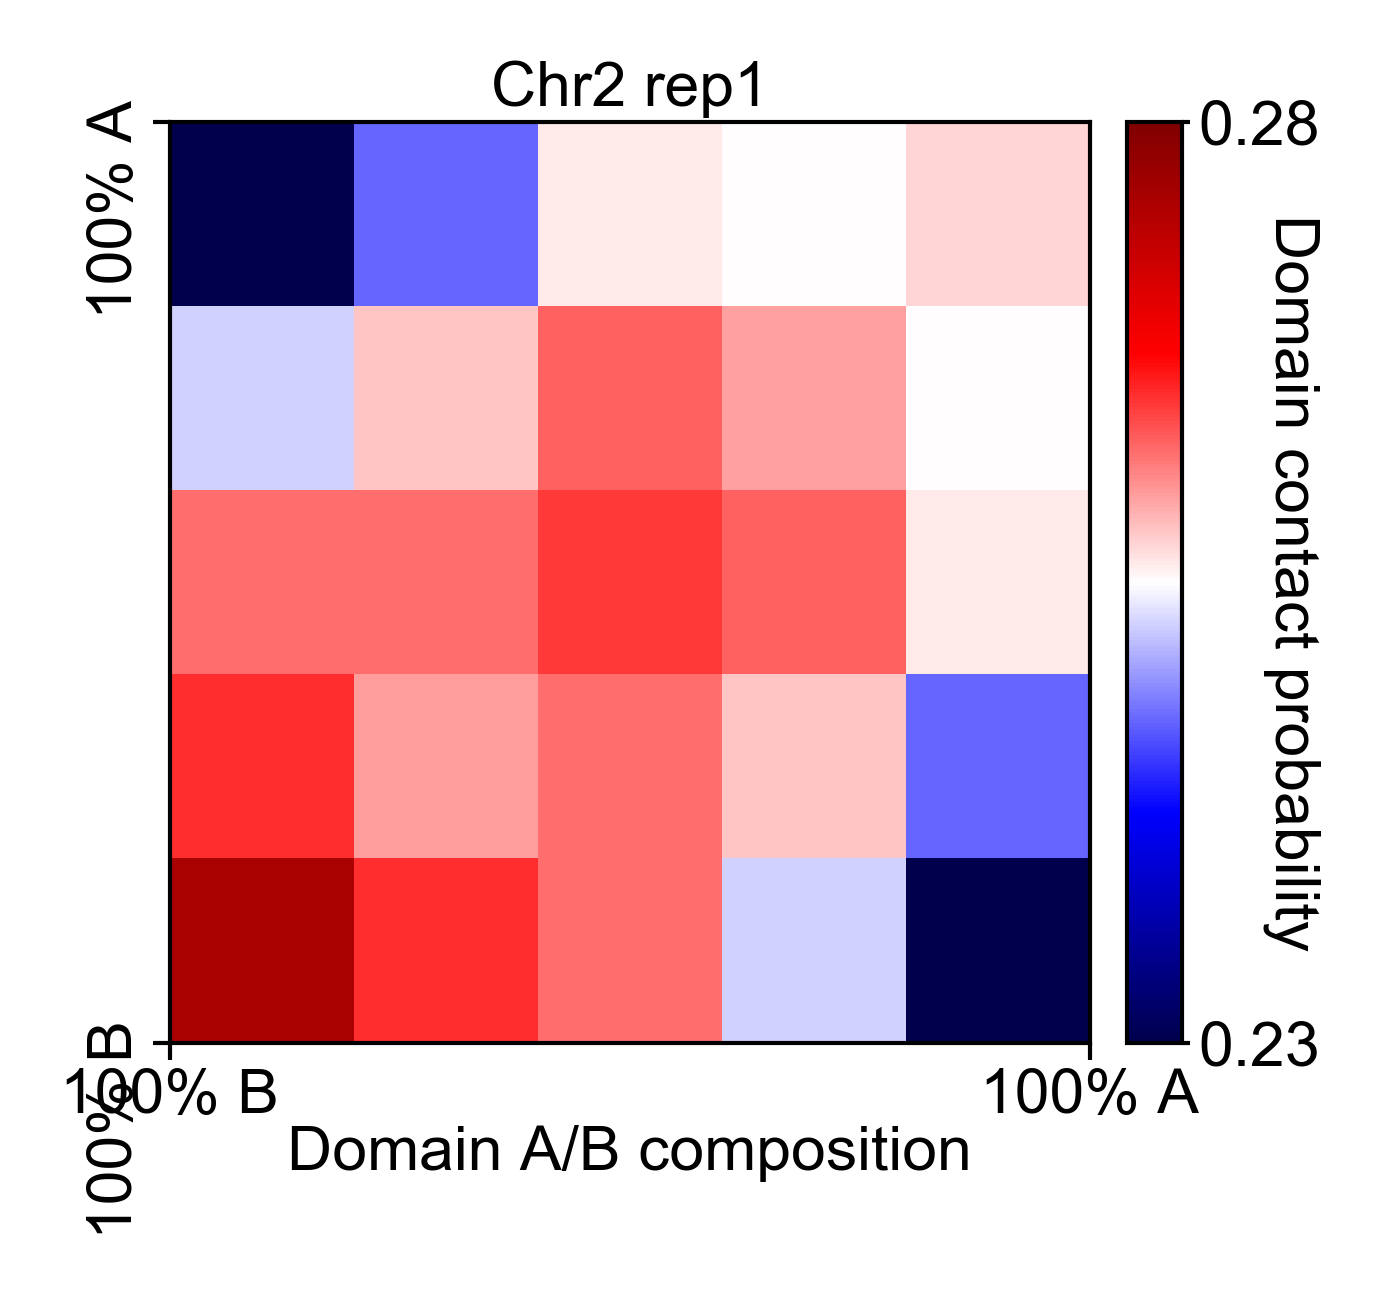

In [66]:
color_limits = [0.23, 0.28]

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=_dpi)

_pf = ax.imshow(rep1_purity_prob_mat, cmap='seismic', interpolation='nearest',
                vmin=min(color_limits), vmax=max(color_limits))

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=True, labelleft=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

ax.set_title(f"Chr2 rep1", 
             fontsize=_font_size, pad=2)
# ticks
_xticks = [-0.5,4.5]
_xtick_labels = ['100% B', '100% A']

ax.set_ylim(_xticks)
ax.set_xlim(_xticks)

ax.set_xticks(_xticks)
ax.set_xticklabels(_xtick_labels)
ax.set_yticks(_xticks)
ax.set_yticklabels(_xtick_labels, rotation=90)

ax.set_xlabel('Domain A/B composition', labelpad=0, fontsize=_font_size)

# locate ax
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax, ticks=color_limits)
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Domain contact probability', fontsize=_font_size, 
               labelpad=0, rotation=270)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1, right=0.85)

#plt.savefig(os.path.join(figure_folder, f'Fig3E_chr2_contact_prob_given_purity_rep1.pdf'), transparent=True)

plt.show()